## DATABASE: Northwind Database 
## OBJECTIVES:
        > Identify customers generating the highest sales and analyze their order patterns and preferences
        > Analyze the performance of different products, including sales trends, profitability, and seasonal effects
        > Evaluate order trends over time, including the impact of promotions and external events
        > Assess the performance and reliability of suppliers based on delivery times, product quality, and order
        fulfillment rates
        > Use time series analysis to forecast future sales and identify potential growth opportunities
        > Analyze the profitability of different product lines and customer segments, and provide recommendations for
        improving margins

## IMPORT THE ESSENTIAL MODULES

In [54]:
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Connecting to the database

In [55]:
# Get the current working directory (where the .ipynb or .py file is located)
current_directory = os.path.dirname(os.path.abspath('__file__'))

database_file = os.path.join(current_directory, 'northwind database.db')
# Connect to the SQLite database
conn = sqlite3.connect(database_file)
cursor = conn.cursor()

# Get the list of tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:")
for i, table in enumerate(tables, start=1):
    print(f"{i}. {table[0]}")

Tables in the database:
1. Categories
2. sqlite_sequence
3. CustomerCustomerDemo
4. CustomerDemographics
5. Customers
6. Employees
7. EmployeeTerritories
8. Order Details
9. Orders
10. Products
11. Regions
12. Shippers
13. Suppliers
14. Territories


In [56]:
# Load data from a specific table into a pandas DataFrame
customers = pd.read_sql_query("SELECT * FROM Customers", conn)
customerDemographics = pd.read_sql_query("SELECT * FROM CustomerDemographics", conn)
employees = pd.read_sql_query("SELECT * FROM Employees", conn)
employeeTerritories = pd.read_sql_query("SELECT * FROM EmployeeTerritories", conn)
orders = pd.read_sql_query("SELECT * FROM Orders", conn)
orderDetails = pd.read_sql_query("SELECT * FROM 'Order Details'", conn)
products = pd.read_sql_query("SELECT * FROM Products", conn)
regions = pd.read_sql_query("SELECT * FROM Regions", conn)
shippers = pd.read_sql_query("SELECT * FROM Shippers", conn)
suppliers = pd.read_sql_query("SELECT * FROM Suppliers", conn)
territories = pd.read_sql_query("SELECT * FROM Territories", conn)
Categories = pd.read_sql_query("SELECT * FROM Categories", conn)
sqlite_sequence = pd.read_sql_query("SELECT * FROM sqlite_sequence", conn)

# Close the database connection
conn.close()

## EXPLORATORY DATA ANALYSIS

# Customers Table

In [57]:
customers.head()

CustomerID                         CompanyName         ContactName  \
0      ALFKI                 Alfreds Futterkiste        Maria Anders   
1      ANATR  Ana Trujillo Emparedados y helados        Ana Trujillo   
2      ANTON             Antonio Moreno Taquería      Antonio Moreno   
3      AROUT                     Around the Horn        Thomas Hardy   
4      BERGS                  Berglunds snabbköp  Christina Berglund   

           ContactTitle                        Address         City  \
0  Sales Representative                  Obere Str. 57       Berlin   
1                 Owner  Avda. de la Constitución 2222  México D.F.   
2                 Owner                Mataderos  2312  México D.F.   
3  Sales Representative                120 Hanover Sq.       London   
4   Order Administrator                Berguvsvägen  8        Luleå   

            Region PostalCode  Country           Phone             Fax  
0   Western Europe      12209  Germany     030-0074321     030-0076545  
1  Central America      05021   Mexico    (5) 555-4729    (5) 555-3745  
2  Central America      05023   Mexico    (5) 555-3932            None  
3    British Isles    WA1 1DP       UK  (171) 555-7788  (171) 555-6750  
4  Northern Europe   S-958 22   Sweden   0921-12 34 65   0921-12 34 67

In [58]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    93 non-null     object
 1   CompanyName   93 non-null     object
 2   ContactName   93 non-null     object
 3   ContactTitle  93 non-null     object
 4   Address       91 non-null     object
 5   City          91 non-null     object
 6   Region        91 non-null     object
 7   PostalCode    90 non-null     object
 8   Country       91 non-null     object
 9   Phone         91 non-null     object
 10  Fax           69 non-null     object
dtypes: object(11)
memory usage: 8.1+ KB


**From the Customers Table, the key columns are: CustomerID, ContactName, and Country**

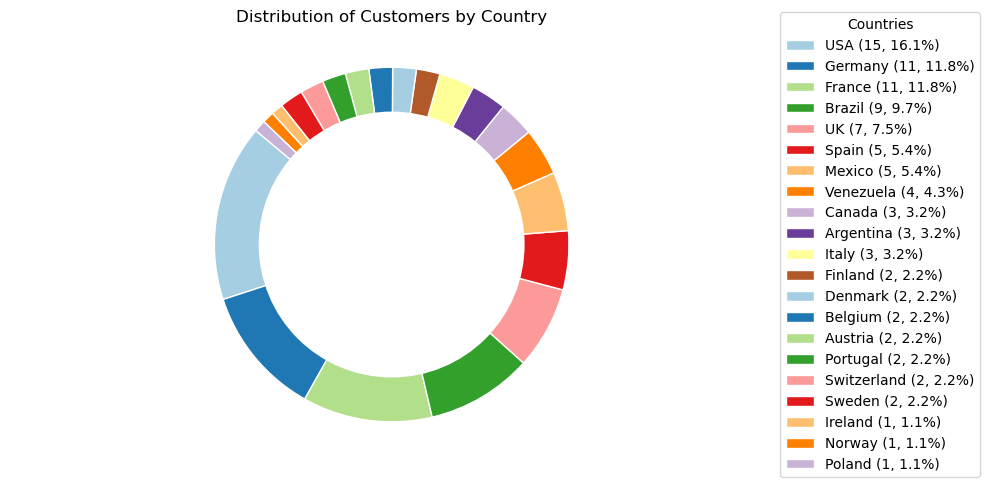

In [59]:
# Aggregate the number of times each customer country
customer_country_counts = customers['Country'].fillna(customers['Country'].mode()[0]).value_counts()

# Calculate percentages
total_customer = customer_country_counts.sum()
percentages = customer_country_counts / total_customer * 100

# Create labels with country name, count, and percentage
labels = [f'{country} ({count}, {percentage:.1f}%)' 
          for country, count, percentage in zip(customer_country_counts.index, 
                                                customer_country_counts.values, 
                                                percentages)]

# Plot the pie chart
plt.figure(figsize=(10, 5))
plt.pie(customer_country_counts, labels=None, startangle=140, colors=plt.cm.Paired.colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# Add the labels outside the wedges
plt.gca().add_artist(plt.Circle((0,0),0.75,fc='white')) # create a white circle in the middle to prevent label overlap
plt.legend(labels, title="Countries", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Customers by Country', y=1.05)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show();

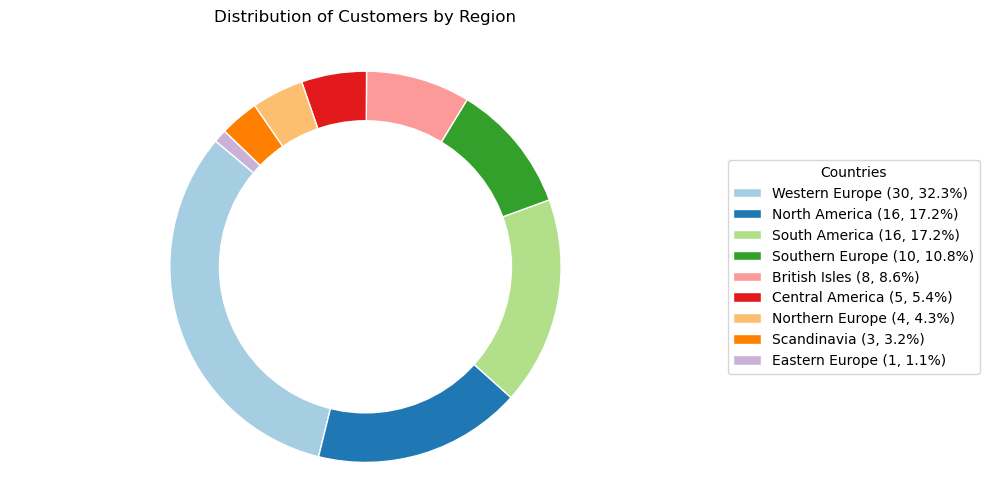

In [60]:
# Aggregate the number of times each customer country
customer_region_counts = customers['Region'].fillna(customers['Region'].mode()[0]).value_counts()

# Calculate percentages
total_customer = customer_region_counts.sum()
percentages = customer_region_counts / total_customer * 100

# Create labels with country name, count, and percentage
labels = [f'{region} ({count}, {percentage:.1f}%)' 
          for region, count, percentage in zip(customer_region_counts.index, 
                                                customer_region_counts.values, 
                                                percentages)]

# Plot the pie chart
plt.figure(figsize=(10, 5))
plt.pie(customer_region_counts, labels=None, startangle=140, colors=plt.cm.Paired.colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# Add the labels outside the wedges
plt.gca().add_artist(plt.Circle((0,0),0.75,fc='white')) # create a white circle in the middle to prevent label overlap
plt.legend(labels, title="Countries", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Customers by Region', y=1.05)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show();

## Orders Table

In [61]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16282 entries, 0 to 16281
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OrderID         16282 non-null  int64  
 1   CustomerID      16282 non-null  object 
 2   EmployeeID      16282 non-null  int64  
 3   OrderDate       16282 non-null  object 
 4   RequiredDate    16282 non-null  object 
 5   ShippedDate     16261 non-null  object 
 6   ShipVia         16282 non-null  int64  
 7   Freight         16282 non-null  float64
 8   ShipName        16282 non-null  object 
 9   ShipAddress     16282 non-null  object 
 10  ShipCity        16282 non-null  object 
 11  ShipRegion      16282 non-null  object 
 12  ShipPostalCode  16110 non-null  object 
 13  ShipCountry     16282 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 1.7+ MB


**Key Fields from the orders Table: OrderID, CustomerID, OrderDate, RequiredDate, ShippedDate, ShipVia, ShipRegion, and ShipCountry**

In [62]:
orderDetails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609283 entries, 0 to 609282
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   OrderID    609283 non-null  int64  
 1   ProductID  609283 non-null  int64  
 2   UnitPrice  609283 non-null  float64
 3   Quantity   609283 non-null  int64  
 4   Discount   609283 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 23.2 MB


**Key Fields from the orders details Table: OrderID, ProductID, UnitPrice, Quantity and Discount.**

## Products Table

In [63]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ProductID        77 non-null     int64  
 1   ProductName      77 non-null     object 
 2   SupplierID       77 non-null     int64  
 3   CategoryID       77 non-null     int64  
 4   QuantityPerUnit  77 non-null     object 
 5   UnitPrice        77 non-null     float64
 6   UnitsInStock     77 non-null     int64  
 7   UnitsOnOrder     77 non-null     int64  
 8   ReorderLevel     77 non-null     int64  
 9   Discontinued     77 non-null     object 
dtypes: float64(1), int64(6), object(3)
memory usage: 6.1+ KB


**Key Fields from the Products Table: ProductID, ProductName, SupplierID, QuantityPerUnit and UnitPrice.**

## Supplier Table

In [64]:
suppliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SupplierID    29 non-null     int64 
 1   CompanyName   29 non-null     object
 2   ContactName   29 non-null     object
 3   ContactTitle  29 non-null     object
 4   Address       29 non-null     object
 5   City          29 non-null     object
 6   Region        28 non-null     object
 7   PostalCode    29 non-null     object
 8   Country       29 non-null     object
 9   Phone         29 non-null     object
 10  Fax           13 non-null     object
 11  HomePage      5 non-null      object
dtypes: int64(1), object(11)
memory usage: 2.8+ KB


# ANSWERING RESEARCH QUESTIONS

## 1. Top Customers by Sales: Identify customers generating the highest sales and analyze their order patterns and preferences.

In [65]:
orderDetailsCopy = orderDetails.copy()

In [66]:
orderDetailsCopy["Discount"].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [67]:
orderDetailsCopy['discountedTotal'] = orderDetailsCopy['UnitPrice'] * orderDetailsCopy['Quantity'] * (1 - orderDetailsCopy['Discount'])
orderDetailsCopy.head()

OrderID  ProductID  UnitPrice  Quantity  Discount  discountedTotal
0    10248         11       14.0        12       0.0            168.0
1    10248         42        9.8        10       0.0             98.0
2    10248         72       34.8         5       0.0            174.0
3    10249         14       18.6         9       0.0            167.4
4    10249         51       42.4        40       0.0           1696.0

In [68]:
print(f'Total Sales: ${orderDetailsCopy["discountedTotal"].sum()}')

Total Sales: $448386633.1695001


In [69]:
orderSummary = orderDetailsCopy.groupby("OrderID")[["Quantity", "discountedTotal"]].sum().reset_index()
orderSummary.head()

OrderID  Quantity  discountedTotal
0    10248        27           440.00
1    10249        49          1863.40
2    10250        60          1552.60
3    10251        41           654.06
4    10252       105          3597.90

In [70]:
customerOrders = pd.merge(orders, orderSummary, on= "OrderID")
customerOrders.head()

OrderID CustomerID  EmployeeID   OrderDate RequiredDate ShippedDate  \
0    10248      VINET           5  2016-07-04   2016-08-01  2016-07-16   
1    10249      TOMSP           6  2016-07-05   2016-08-16  2016-07-10   
2    10250      HANAR           4  2016-07-08   2016-08-05  2016-07-12   
3    10251      VICTE           3  2016-07-08   2016-08-05  2016-07-15   
4    10252      SUPRD           4  2016-07-09   2016-08-06  2016-07-11   

   ShipVia  Freight                   ShipName           ShipAddress  \
0        3    16.75  Vins et alcools Chevalier    59 rue de l-Abbaye   
1        1    22.25         Toms Spezialitäten         Luisenstr. 48   
2        2    25.00              Hanari Carnes       Rua do Paço, 67   
3        1    20.25       Victuailles en stock    2, rue du Commerce   
4        2    36.25           Suprêmes délices  Boulevard Tirou, 255   

         ShipCity      ShipRegion ShipPostalCode ShipCountry  Quantity  \
0           Reims  Western Europe          51100      France        27   
1         Münster  Western Europe          44087     Germany        49   
2  Rio de Janeiro   South America      05454-876      Brazil        60   
3            Lyon  Western Europe          69004      France        41   
4       Charleroi  Western Europe         B-6000     Belgium       105   

   discountedTotal  
0           440.00  
1          1863.40  
2          1552.60  
3           654.06  
4          3597.90

In [71]:
customerDetails = customers[["CustomerID", "ContactName", "Country", "Region"]]
customerDetails.head()

CustomerID         ContactName  Country           Region
0      ALFKI        Maria Anders  Germany   Western Europe
1      ANATR        Ana Trujillo   Mexico  Central America
2      ANTON      Antonio Moreno   Mexico  Central America
3      AROUT        Thomas Hardy       UK    British Isles
4      BERGS  Christina Berglund   Sweden  Northern Europe

In [72]:
customerOrdersDetails = pd.merge(customerDetails, customerOrders, on= "CustomerID")
customerOrdersDetails.head()

CustomerID   ContactName  Country          Region  OrderID  EmployeeID  \
0      ALFKI  Maria Anders  Germany  Western Europe    10643           6   
1      ALFKI  Maria Anders  Germany  Western Europe    10692           4   
2      ALFKI  Maria Anders  Germany  Western Europe    10702           4   
3      ALFKI  Maria Anders  Germany  Western Europe    10835           1   
4      ALFKI  Maria Anders  Germany  Western Europe    10952           1   

    OrderDate RequiredDate ShippedDate  ShipVia  Freight  \
0  2017-08-25   2017-09-22  2017-09-02        1    19.50   
1  2017-10-03   2017-10-31  2017-10-13        2    15.00   
2  2017-10-13   2017-11-24  2017-10-21        1    15.25   
3  2018-01-15   2018-02-12  2018-01-21        3    14.25   
4  2018-03-16   2018-04-27  2018-03-24        1    14.50   

               ShipName    ShipAddress ShipCity      ShipRegion  \
0   Alfreds Futterkiste  Obere Str. 57   Berlin  Western Europe   
1  Alfred-s Futterkiste  Obere Str. 57   Berlin  Western Europe   
2  Alfred-s Futterkiste  Obere Str. 57   Berlin  Western Europe   
3  Alfred-s Futterkiste  Obere Str. 57   Berlin  Western Europe   
4  Alfred-s Futterkiste  Obere Str. 57   Berlin  Western Europe   

  ShipPostalCode ShipCountry  Quantity  discountedTotal  
0          12209     Germany        38            814.5  
1          12209     Germany        20            878.0  
2          12209     Germany        21            330.0  
3          12209     Germany        17            845.8  
4          12209     Germany        18            471.2

In [73]:
topCustomers = customerOrdersDetails.groupby(['CustomerID', 'ContactName'])[["Quantity", "discountedTotal"]].sum().reset_index()
topCustomers = topCustomers.sort_values(by="discountedTotal", ascending = False)
top10 = topCustomers.head(10).reset_index(drop=True)
top10

CustomerID        ContactName  Quantity  discountedTotal
0      BSBEV  Victoria Ashworth    210789     6.154115e+06
1      HUNGC      Yoshi Latimer    198468     5.698024e+06
2      RANCH   Sergio Gutiérrez    189636     5.559110e+06
3      GOURL      André Fonseca    191676     5.552310e+06
4      ANATR       Ana Trujillo    190964     5.534357e+06
5      RICAR     Janete Limeira    193021     5.524517e+06
6      FOLIG      Martine Rancé    190006     5.505503e+06
7      LETSS       Jaime Yorres    188887     5.462198e+06
8      LILAS    Carlos González    185506     5.437438e+06
9      PRINI   Isabel de Castro    190001     5.436771e+06

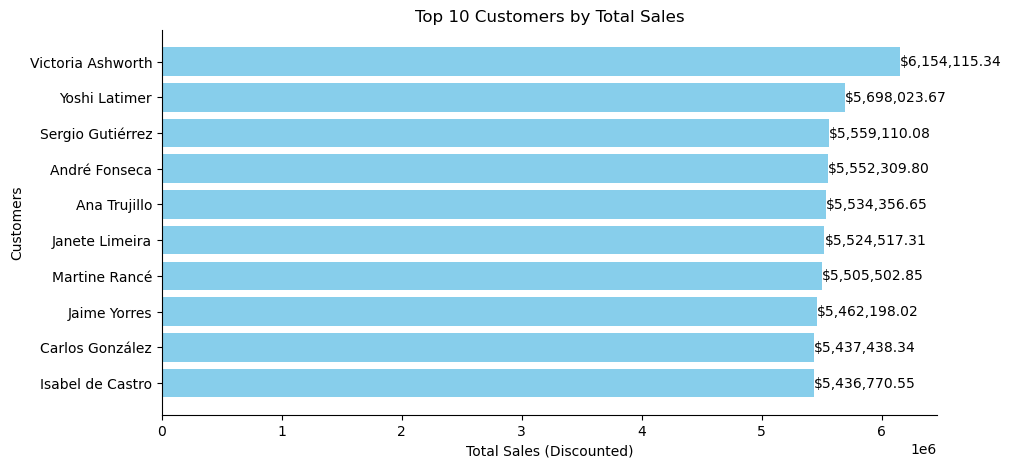

In [74]:
# Plot the horizontal bar chart
plt.figure(figsize=(10, 5))
bars = plt.barh(top10['ContactName'], top10['discountedTotal'], color='skyblue')

# Invert y-axis to have the highest spending customer on top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Total Sales (Discounted)')
plt.ylabel('Customers')
plt.title('Top 10 Customers by Total Sales')

# Remove the top and right axes lines
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the total at the apex of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'${bar.get_width():,.2f}', 
             va='center', ha='left', fontsize=10, color='black')

# Show the plot
plt.show();

In [75]:
## Order Frequency
customer_sales = customerOrdersDetails.groupby(['CustomerID', 'ContactName'])[["Quantity", "discountedTotal"]].sum().reset_index()

# Calculate the number of orders per customer
order_frequency = customerOrdersDetails.groupby(['CustomerID', 'ContactName'])['OrderID'].nunique().reset_index()
order_frequency = order_frequency.rename(columns={'OrderID': 'OrderCount'})

# Merge with customer_sales to combine with sales data
customer_analysis = pd.merge(customer_sales, order_frequency, on=['CustomerID', 'ContactName'])

# Display the result
customer_analysis.sort_values(by='discountedTotal', ascending=False).head(10).reset_index(drop=True)

CustomerID        ContactName  Quantity  discountedTotal  OrderCount
0      BSBEV  Victoria Ashworth    210789     6.154115e+06         210
1      HUNGC      Yoshi Latimer    198468     5.698024e+06         198
2      RANCH   Sergio Gutiérrez    189636     5.559110e+06         194
3      GOURL      André Fonseca    191676     5.552310e+06         202
4      ANATR       Ana Trujillo    190964     5.534357e+06         195
5      RICAR     Janete Limeira    193021     5.524517e+06         203
6      FOLIG      Martine Rancé    190006     5.505503e+06         195
7      LETSS       Jaime Yorres    188887     5.462198e+06         191
8      LILAS    Carlos González    185506     5.437438e+06         203
9      PRINI   Isabel de Castro    190001     5.436771e+06         200

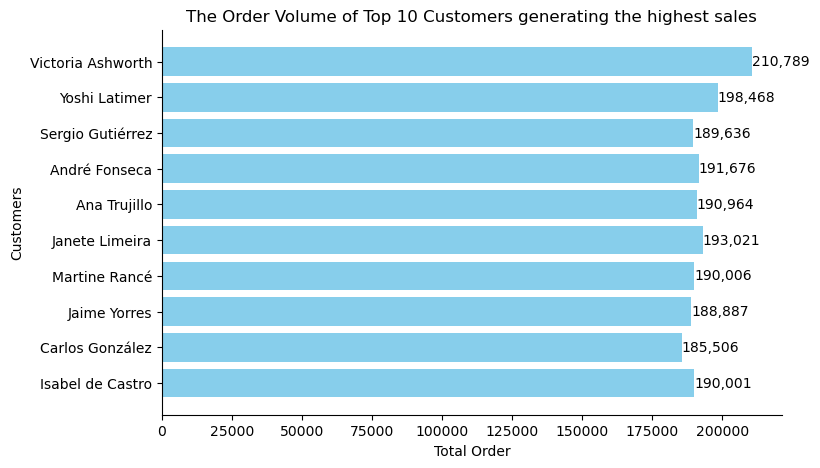

In [76]:
# Plot an horizontal bar chart for the Order Volume
plt.figure(figsize=(8, 5))
top10Customers = customer_analysis.sort_values(by='discountedTotal', ascending=False).head(10)
bars = plt.barh(top10Customers['ContactName'], top10Customers['Quantity'], color='skyblue')

# Invert y-axis to have the highest spending customer on top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Total Order')
plt.ylabel('Customers')
plt.title('The Order Volume of Top 10 Customers generating the highest sales')

# Remove the top and right axes lines
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the total at the apex of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,}', 
             va='center', ha='left', fontsize=10, color='black')

# Show the plot
plt.show();

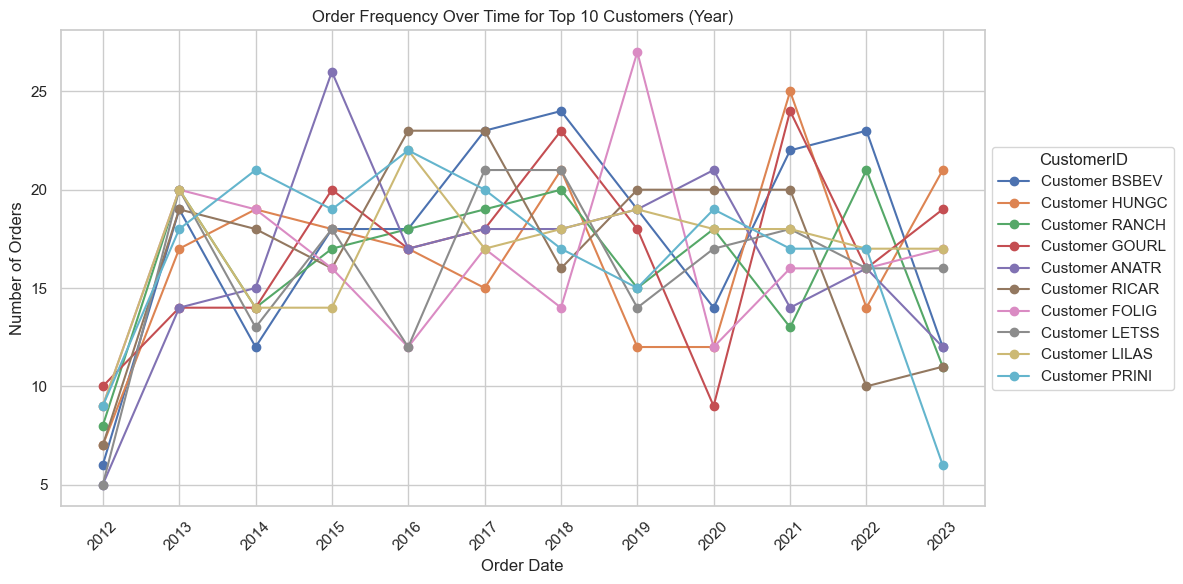

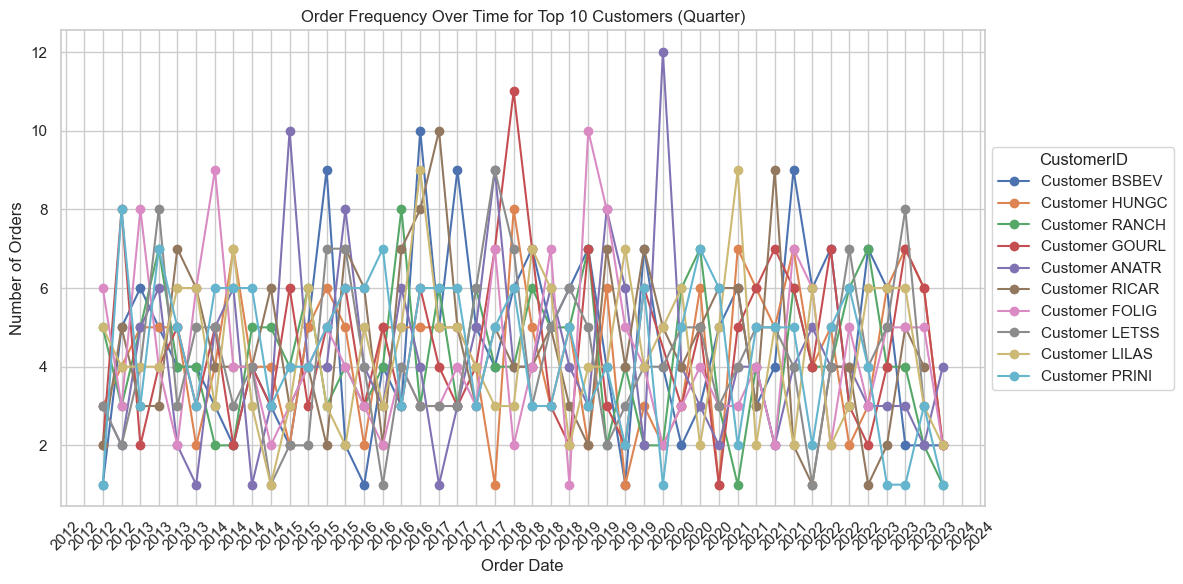

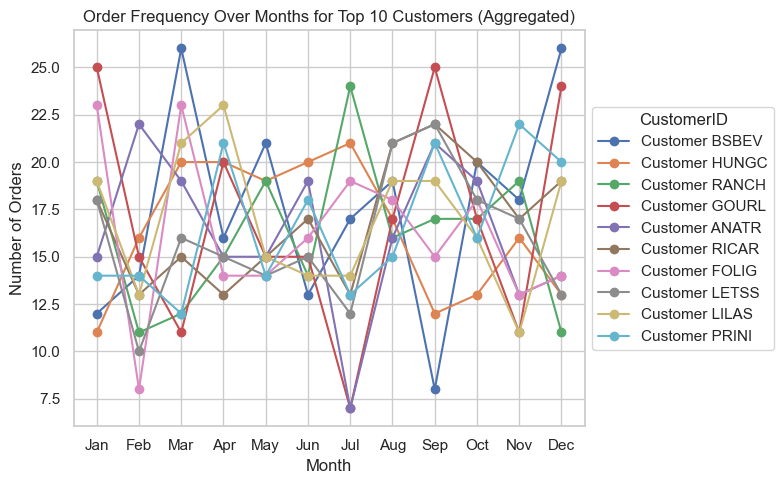

In [86]:
warnings.filterwarnings("ignore")
customerfullOrdersDetails = customerOrdersDetails.copy()

# Convert 'OrderDate' to datetime
customerfullOrdersDetails['OrderDate'] = pd.to_datetime(customerfullOrdersDetails['OrderDate'], format='mixed')

# Identify the top 10 customers based on 'discountedTotal'
top_customers = customerfullOrdersDetails.groupby('CustomerID')['discountedTotal'].sum().nlargest(10).reset_index()

# Function to aggregate data by different time periods
def aggregate_by_period(data, period):
    if period == 'year':
        data['Period'] = data['OrderDate'].dt.to_period('Y')
    elif period == 'quarter':
        data['Period'] = data['OrderDate'].dt.to_period('Q')
    else:  # month
        data['Period'] = data['OrderDate'].dt.to_period('M')
    
    return data.groupby(['Period', 'CustomerID'])['OrderID'].nunique().reset_index()

# Plot function for yearly and quarterly data
def plot_order_frequency(period='year'):
    order_timing = customerfullOrdersDetails[customerfullOrdersDetails['CustomerID'].isin(top_customers['CustomerID'])]
    order_timing = aggregate_by_period(order_timing, period)
    
    # Convert 'Period' to datetime for proper plotting
    order_timing['Period'] = order_timing['Period'].dt.to_timestamp()

    plt.figure(figsize=(12, 6))

    # Plot for each of the top customers
    for customer in top_customers['CustomerID']:
        customer_data = order_timing[order_timing['CustomerID'] == customer]
        plt.plot(customer_data['Period'], customer_data['OrderID'], label=f'Customer {customer}', marker='o')

    plt.title(f'Order Frequency Over Time for Top 10 Customers ({period.capitalize()})')
    plt.xlabel('Order Date')
    plt.ylabel('Number of Orders')
    plt.legend(title='CustomerID', loc='center left', bbox_to_anchor=(1, 0.5))

    # Set x-axis format based on the period
    if period == 'year':
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    elif period == 'quarter':
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    else:  # month
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function to aggregate data by month irrespective of the year
def aggregate_by_month(data):
    data['Month'] = data['OrderDate'].dt.month
    return data.groupby(['Month', 'CustomerID'])['OrderID'].nunique().reset_index()

# Plot function for monthly aggregation irrespective of the year
def plot_order_frequency_by_month():
    order_timing = customerfullOrdersDetails[customerfullOrdersDetails['CustomerID'].isin(top_customers['CustomerID'])]
    order_timing = aggregate_by_month(order_timing)
    
    plt.figure(figsize=(8, 5))

    # Plot for each of the top customers
    for customer in top_customers['CustomerID']:
        customer_data = order_timing[order_timing['CustomerID'] == customer]
        plt.plot(customer_data['Month'], customer_data['OrderID'], label=f'Customer {customer}', marker='o')

    plt.title(f'Order Frequency Over Months for Top 10 Customers (Aggregated)')
    plt.xlabel('Month')
    plt.ylabel('Number of Orders')
    plt.legend(title='CustomerID', loc='center left', bbox_to_anchor=(1, 0.5))

    # Set x-axis labels as months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.tight_layout()
    plt.show()

# Call the plot functions
plot_order_frequency('year')    # Yearly plot
plot_order_frequency('quarter') # Quarterly plot
plot_order_frequency_by_month() # Monthly aggregated plot

In [131]:
shippingPreferenceData= customerOrdersDetails.copy()
shippingPreferenceData.head()

CustomerID   ContactName  Country          Region  OrderID  EmployeeID  \
0      ALFKI  Maria Anders  Germany  Western Europe    10643           6   
1      ALFKI  Maria Anders  Germany  Western Europe    10692           4   
2      ALFKI  Maria Anders  Germany  Western Europe    10702           4   
3      ALFKI  Maria Anders  Germany  Western Europe    10835           1   
4      ALFKI  Maria Anders  Germany  Western Europe    10952           1   

    OrderDate RequiredDate ShippedDate  ShipVia  Freight  \
0  2017-08-25   2017-09-22  2017-09-02        1    19.50   
1  2017-10-03   2017-10-31  2017-10-13        2    15.00   
2  2017-10-13   2017-11-24  2017-10-21        1    15.25   
3  2018-01-15   2018-02-12  2018-01-21        3    14.25   
4  2018-03-16   2018-04-27  2018-03-24        1    14.50   

               ShipName    ShipAddress ShipCity      ShipRegion  \
0   Alfreds Futterkiste  Obere Str. 57   Berlin  Western Europe   
1  Alfred-s Futterkiste  Obere Str. 57   Berlin  Western Europe   
2  Alfred-s Futterkiste  Obere Str. 57   Berlin  Western Europe   
3  Alfred-s Futterkiste  Obere Str. 57   Berlin  Western Europe   
4  Alfred-s Futterkiste  Obere Str. 57   Berlin  Western Europe   

  ShipPostalCode ShipCountry  Quantity  discountedTotal  
0          12209     Germany        38            814.5  
1          12209     Germany        20            878.0  
2          12209     Germany        21            330.0  
3          12209     Germany        17            845.8  
4          12209     Germany        18            471.2

In [136]:
# Filter the data to include only the top 10 customers
top_customers_data = shippingPreferenceData[shippingPreferenceData['CustomerID'].isin(top10['CustomerID'])]

# Create a pivot table to calculate shipping preferences by the top 10 customers
shipping_preference = top_customers_data.pivot_table(
    index=['CustomerID', 'ContactName'], 
    columns='ShipVia', 
    values='OrderID',  # You can also use 'discountedTotal' to base it on sales value instead of order count
    aggfunc='count',   # 'count' for order count, 'sum' for total sales
    fill_value=0       # Replace NaN with 0 for better readability
)

# Normalize the pivot table to show the percentage preference for each shipping method by each customer
shipping_preference_percentage = shipping_preference.div(shipping_preference.sum(axis=1), axis=0) * 100

# Display the results
print("Shipping Preference (Raw Counts):\n")
shipping_preference

Shipping Preference (Raw Counts):



ShipVia                        1   2   3
CustomerID ContactName                  
ANATR      Ana Trujillo       69  57  69
BSBEV      Victoria Ashworth  63  68  79
FOLIG      Martine Rancé      60  70  65
GOURL      André Fonseca      61  77  64
HUNGC      Yoshi Latimer      66  62  70
LETSS      Jaime Yorres       72  61  58
LILAS      Carlos González    67  77  59
PRINI      Isabel de Castro   56  79  65
RANCH      Sergio Gutiérrez   61  65  68
RICAR      Janete Limeira     68  61  74

In [135]:
print("\nShipping Preference Percentage:")
shipping_preference_percentage


Shipping Preference Percentage:


ShipVia                       Speedy Express  United Package  Federal Shipping
CustomerID ContactName                                                        
ANATR      Ana Trujillo            35.384615       29.230769         35.384615
BSBEV      Victoria Ashworth       30.000000       32.380952         37.619048
FOLIG      Martine Rancé           30.769231       35.897436         33.333333
GOURL      André Fonseca           30.198020       38.118812         31.683168
HUNGC      Yoshi Latimer           33.333333       31.313131         35.353535
LETSS      Jaime Yorres            37.696335       31.937173         30.366492
LILAS      Carlos González         33.004926       37.931034         29.064039
PRINI      Isabel de Castro        28.000000       39.500000         32.500000
RANCH      Sergio Gutiérrez        31.443299       33.505155         35.051546
RICAR      Janete Limeira          33.497537       30.049261         36.453202

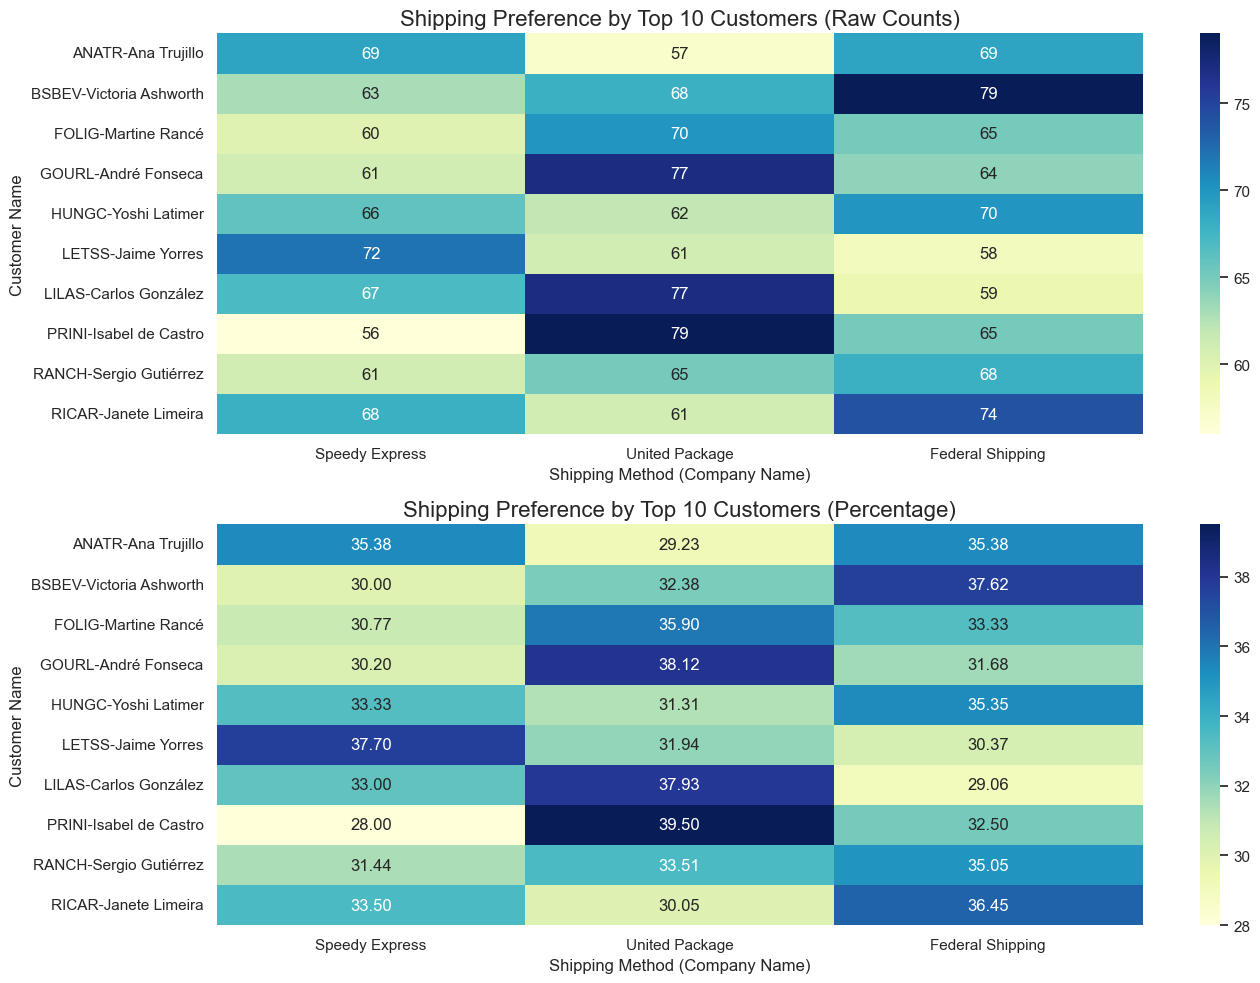

In [134]:
# Replace ShipVia with CompanyName in shipping_preference
shipping_preference = shipping_preference.rename(columns=shippers.set_index('ShipperID')['CompanyName'])

# Replace ShipVia with CompanyName in shipping_preference_percentage
shipping_preference_percentage = shipping_preference_percentage.rename(columns=shippers.set_index('ShipperID')['CompanyName'])

# Visualization of Heatmaps with Company Names
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

# Create a heatmap for shipping preferences (raw counts)
plt.subplot(2, 1, 1)
sns.heatmap(shipping_preference, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title('Shipping Preference by Top 10 Customers (Raw Counts)', fontsize=16)
plt.xlabel('Shipping Method (Company Name)', fontsize=12)
plt.ylabel('Customer Name', fontsize=12)

# Create a heatmap for shipping preferences (percentage)
plt.subplot(2, 1, 2)
sns.heatmap(shipping_preference_percentage, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title('Shipping Preference by Top 10 Customers (Percentage)', fontsize=16)
plt.xlabel('Shipping Method (Company Name)', fontsize=12)
plt.ylabel('Customer Name', fontsize=12)

# Adjust layout for better display
plt.tight_layout()
plt.show();

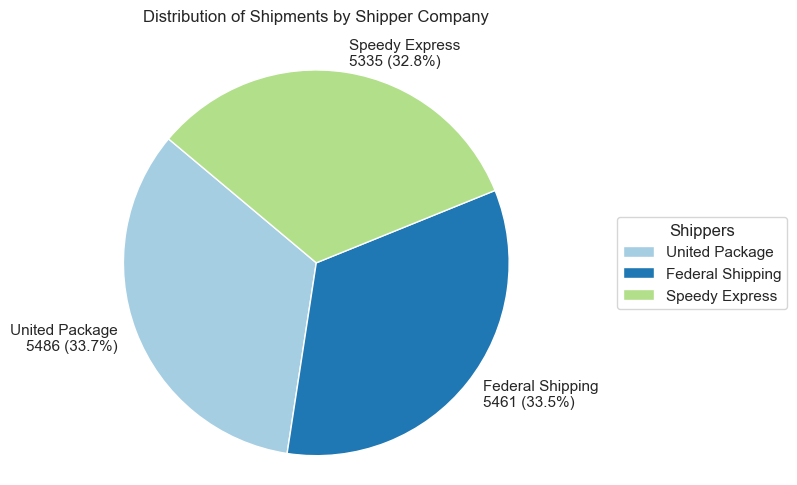

In [82]:
# Merge the Orders and Shippers DataFrame to replace ShipVia with CompanyName
orders_with_shipper_names = pd.merge(orders, shippers, left_on='ShipVia', right_on='ShipperID')

# Aggregate the number of times each shipper is used
shipper_usage_counts = orders_with_shipper_names['CompanyName'].value_counts()

# Calculate percentages
total_shipments = shipper_usage_counts.sum()
percentages = shipper_usage_counts / total_shipments * 100

# Create labels with company name, count, and percentage
labels = [f'{company}\n{count} ({percentage:.1f}%)' 
          for company, count, percentage in zip(shipper_usage_counts.index, 
                                                shipper_usage_counts.values, 
                                                percentages)]

# Plot the pie chart
plt.figure(figsize=(8, 5))
plt.pie(shipper_usage_counts, labels=labels, autopct='', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Shipments by Shipper Company', y=1.05)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a legend
plt.legend(shipper_usage_counts.index, title="Shippers", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show();

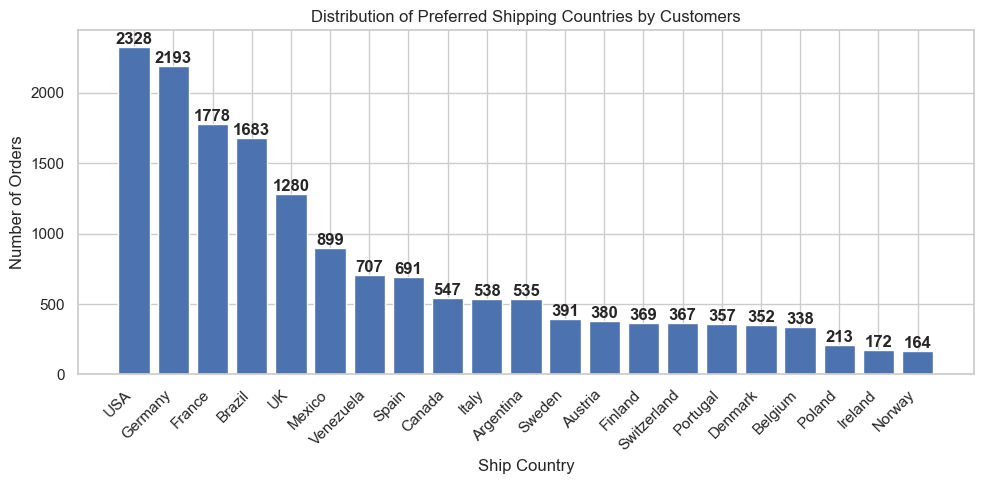

In [83]:
# Count the number of orders for each country
country_distribution = orders['ShipCountry'].value_counts()

# Create a vertical bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(country_distribution.index, country_distribution.values)

# Add labels and title
plt.ylabel('Number of Orders')
plt.xlabel('Ship Country')
plt.title('Distribution of Preferred Shipping Countries by Customers')

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', 
             ha='center', va='bottom', fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show();

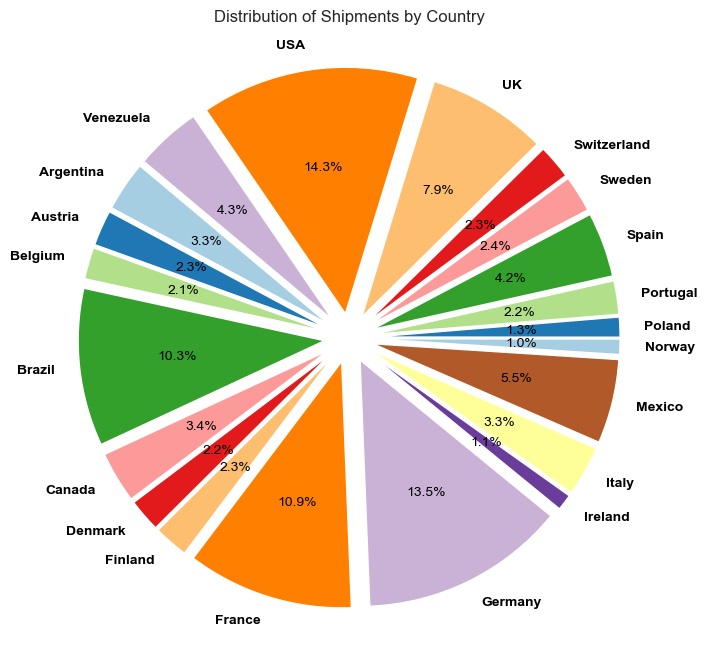

In [94]:
# Group by ShipCountry to get the count of shipments per country
ship_country_distribution = shippingPreferenceData.groupby('ShipCountry').size().reset_index(name='Count')

# Define the explode parameter to highlight certain slices (optional)
explode = [0.1] * len(ship_country_distribution)  # Explode all slices equally

# Plot the pie chart with customizations
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    ship_country_distribution['Count'],
    labels=ship_country_distribution['ShipCountry'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors,
    explode=explode
)

# Customize the labels to be outside the chart
for text in texts:
    text.set_fontsize(10)
    text.set_color('black')
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')

# Add a title
plt.title('Distribution of Shipments by Country')

# Display the pie chart
plt.show();

In [ ]:
# Shipping Preferences for Customers

# Create a pivot table to analyze shipping preferences by counting occurrences
shipping_plot = orders_with_shipper_names.pivot_table(index="ShipCountry", columns="CompanyName", aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(shipping_plot, annot=True, cmap='coolwarm', fmt='g')

plt.title('Shipping Preferences for Customers (by Country and ShipVia)')
plt.xlabel('Shipping Method (ShipVia)')
plt.ylabel('Shipping Country')
plt.show();

# QUESTION 2: 
## Product Performance: Analyze the performance of different products, including sales trends, profitability, and seasonal effects

In [95]:
products.head()

ProductID                   ProductName  SupplierID  CategoryID  \
0          1                          Chai           1           1   
1          2                         Chang           1           1   
2          3                 Aniseed Syrup           1           2   
3          4  Chef Anton's Cajun Seasoning           2           2   
4          5        Chef Anton's Gumbo Mix           2           2   

       QuantityPerUnit  UnitPrice  UnitsInStock  UnitsOnOrder  ReorderLevel  \
0   10 boxes x 20 bags      18.00            39             0            10   
1   24 - 12 oz bottles      19.00            17            40            25   
2  12 - 550 ml bottles      10.00            13            70            25   
3       48 - 6 oz jars      22.00            53             0             0   
4             36 boxes      21.35             0             0             0   

  Discontinued  
0            0  
1            0  
2            0  
3            0  
4            1

In [96]:
orderDetailsCopy.head()

OrderID  ProductID  UnitPrice  Quantity  Discount  discountedTotal
0    10248         11       14.0        12       0.0            168.0
1    10248         42        9.8        10       0.0             98.0
2    10248         72       34.8         5       0.0            174.0
3    10249         14       18.6         9       0.0            167.4
4    10249         51       42.4        40       0.0           1696.0

In [97]:
merged_data = pd.merge(orderDetails, products, on='ProductID')
merged_data = pd.merge(merged_data, orders, on='OrderID')

# Convert OrderDate to datetime
merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], format='mixed')

# Calculate total sales and profit
merged_data['TotalSales'] = merged_data['Quantity'] * merged_data['UnitPrice_x'] * (1 - merged_data['Discount'])
merged_data['Profit'] = merged_data['TotalSales'] - (merged_data['Quantity'] * merged_data['UnitPrice_y'])

In [98]:
merged_data.head()

OrderID  ProductID  UnitPrice_x  Quantity  Discount  \
0    10248         11         14.0        12       0.0   
1    10248         42          9.8        10       0.0   
2    10248         72         34.8         5       0.0   
3    10296         11         16.8        12       0.0   
4    10296         16         13.9        30       0.0   

                     ProductName  SupplierID  CategoryID   QuantityPerUnit  \
0                 Queso Cabrales           5           4         1 kg pkg.   
1  Singaporean Hokkien Fried Mee          20           5   32 - 1 kg pkgs.   
2         Mozzarella di Giovanni          14           4  24 - 200 g pkgs.   
3                 Queso Cabrales           5           4         1 kg pkg.   
4                        Pavlova           7           3  32 - 500 g boxes   

   UnitPrice_y  ...  ShipVia  Freight                   ShipName  \
0        21.00  ...        3    16.75  Vins et alcools Chevalier   
1        14.00  ...        3    16.75  Vins et alcools Chevalier   
2        34.80  ...        3    16.75  Vins et alcools Chevalier   
3        21.00  ...        1    24.25          LILA-Supermercado   
4        17.45  ...        1    24.25          LILA-Supermercado   

                                      ShipAddress      ShipCity  \
0                              59 rue de l-Abbaye         Reims   
1                              59 rue de l-Abbaye         Reims   
2                              59 rue de l-Abbaye         Reims   
3  Carrera 52 con Ave. Bolívar #65-98 Llano Largo  Barquisimeto   
4  Carrera 52 con Ave. Bolívar #65-98 Llano Largo  Barquisimeto   

       ShipRegion ShipPostalCode ShipCountry TotalSales  Profit  
0  Western Europe          51100      France      168.0   -84.0  
1  Western Europe          51100      France       98.0   -42.0  
2  Western Europe          51100      France      174.0     0.0  
3   South America           3508   Venezuela      201.6   -50.4  
4   South America           3508   Venezuela      417.0  -106.5  

[5 rows x 29 columns]

In [137]:
# 1. Top 10 Products by Total Sales

# Grouping data to get top 10 products by total sales
top_10_sales = merged_data.groupby('ProductName')[['Quantity', 'TotalSales', 'Profit']].sum().nlargest(10, "TotalSales").reset_index()
top_10_sales

ProductName  Quantity    TotalSales     Profit
0            Côte de Blaye    202234  5.326590e+07 -22763.765
1  Thüringer Rostbratwurst    199010  2.462347e+07 -11978.668
2          Mishi Kobe Niku    200258  1.942304e+07  -1988.500
3   Sir Rodney's Marmalade    205637  1.665381e+07  -2789.640
4         Carnarvon Tigers    201747  1.260467e+07  -4515.625
5     Raclette Courdavault    204137  1.121641e+07 -11124.300
6    Manjimup Dried Apples    201319  1.066477e+07  -5138.350
7           Tarte au sucre    202010  9.952936e+06  -6156.930
8              Ipoh Coffee    202968  9.333375e+06  -3153.300
9        Rössle Sauerkraut    202988  9.252765e+06  -3487.360

In [100]:
# Top 10 Products by Order Volume
top_10_sales = merged_data.groupby('ProductName')[['Quantity', 'TotalSales']].sum().nlargest(10, "Quantity").reset_index()
top_10_sales

ProductName  Quantity    TotalSales
0        Louisiana Hot Spiced Okra    206213  3.504941e+06
1           Sir Rodney's Marmalade    205637  1.665381e+07
2       Teatime Chocolate Biscuits    205487  1.889691e+06
3                   Sirop d'érable    205005  5.839810e+06
4              Gumbär Gummibärchen    204761  6.391019e+06
5                    Outback Lager    204403  3.064463e+06
6                   Ravioli Angelo    204251  3.982093e+06
7             Raclette Courdavault    204137  1.121641e+07
8  Uncle Bob's Organic Dried Pears    203970  6.118254e+06
9                    Sasquatch Ale    203667  2.850604e+06

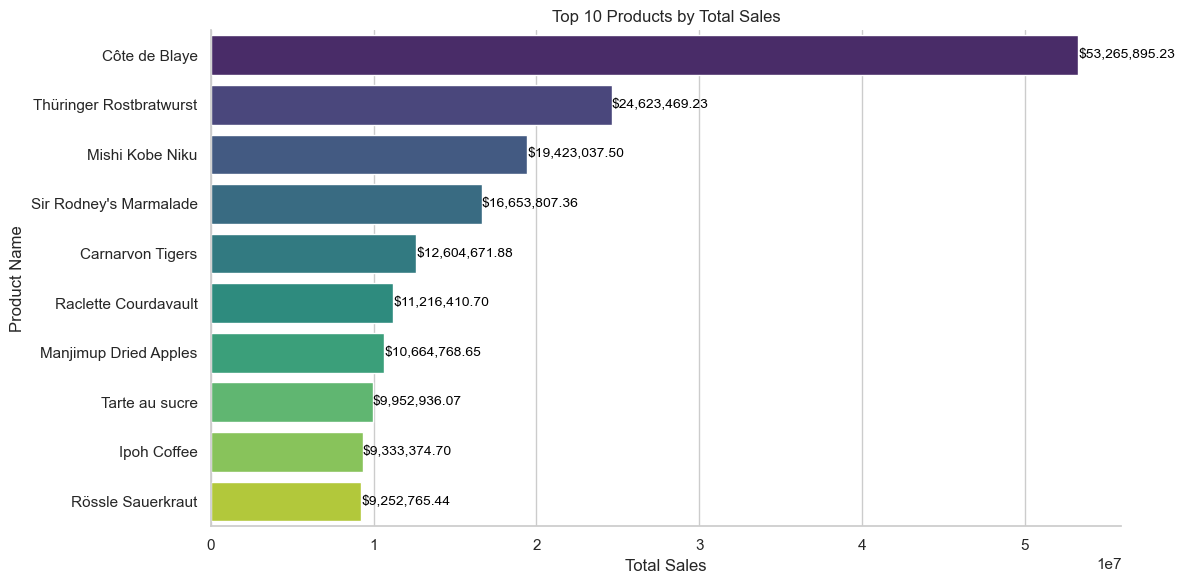

In [138]:
# Sort the DataFrame by TotalSales in descending order
# Create the bar plot
plt.figure(figsize=(12, 6))
bars = sns.barplot(x='TotalSales', y='ProductName', data=top_10_sales, palette='viridis')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')

# Adding labels to the bars
for bar in bars.containers[0]:
    plt.text(bar.get_width(), 
             bar.get_y() + bar.get_height()/2, 
             f'${bar.get_width():,.2f}', 
             va='center', ha='left', 
             fontsize=10, color='black')
    
# Customize the plot appearance
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show();

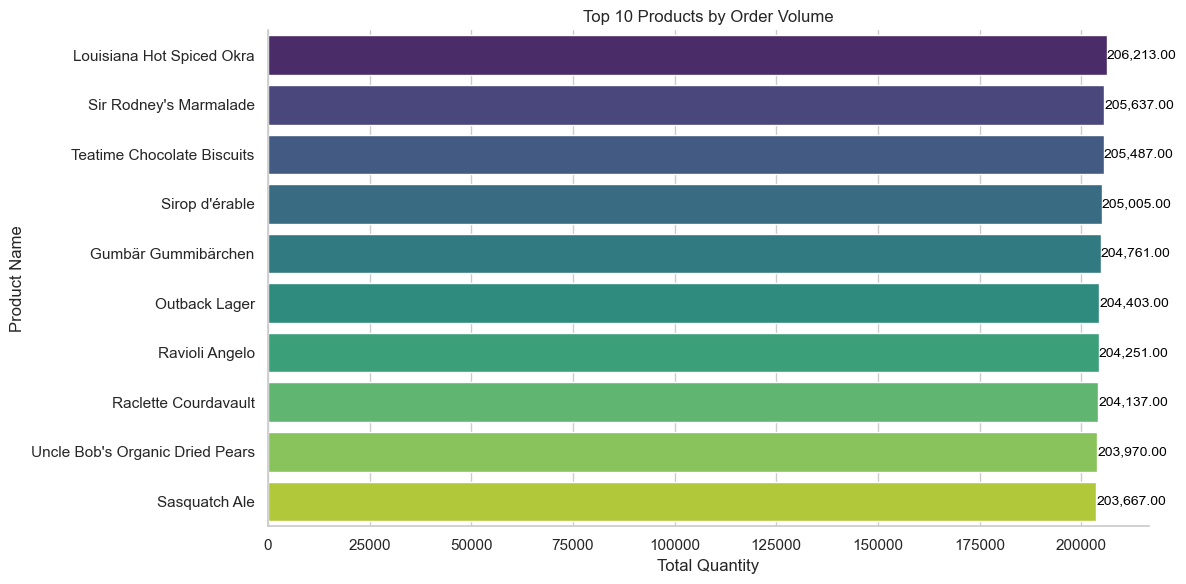

In [102]:
# Most ordered Products
plt.figure(figsize=(12, 6))
bars = sns.barplot(x='Quantity', y='ProductName', data=top_10_sales, palette='viridis')
plt.title('Top 10 Products by Order Volume')
plt.xlabel('Total Quantity')
plt.ylabel('Product Name')

# Adding labels to the bars
for bar in bars.containers[0]:
    plt.text(bar.get_width(), 
             bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():,.2f}', 
             va='center', ha='left', 
             fontsize=10, color='black')
    
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show();

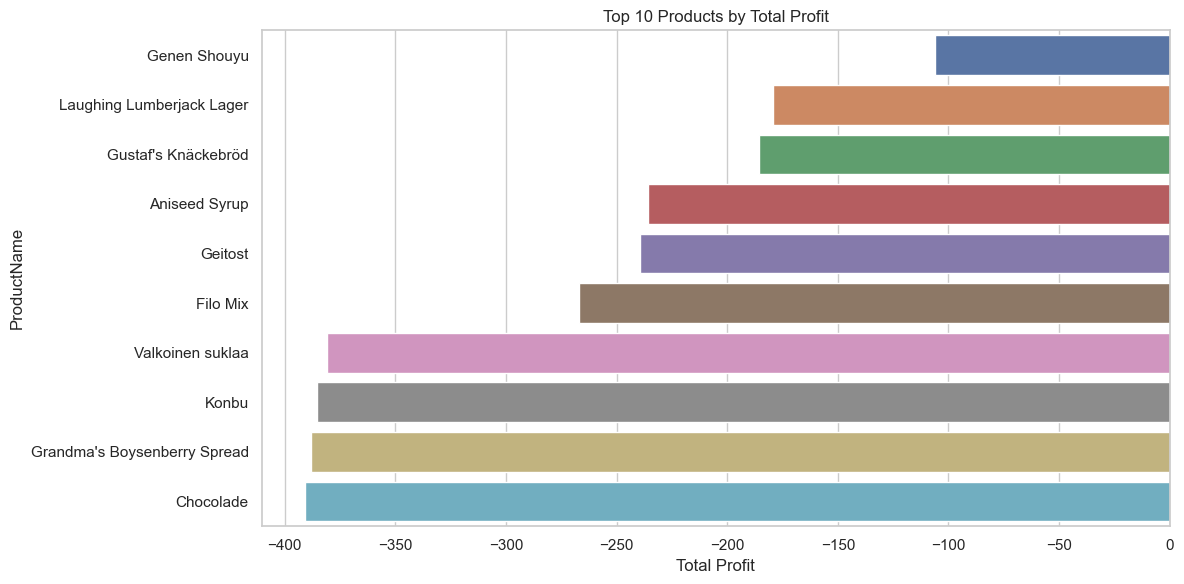

In [103]:
# Top 10 Products by Profit
top_10_profit = merged_data.groupby('ProductName')['Profit'].sum().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Profit', y='ProductName', data=top_10_profit)
plt.title('Top 10 Products by Total Profit')
plt.xlabel('Total Profit')
plt.tight_layout()
plt.show();

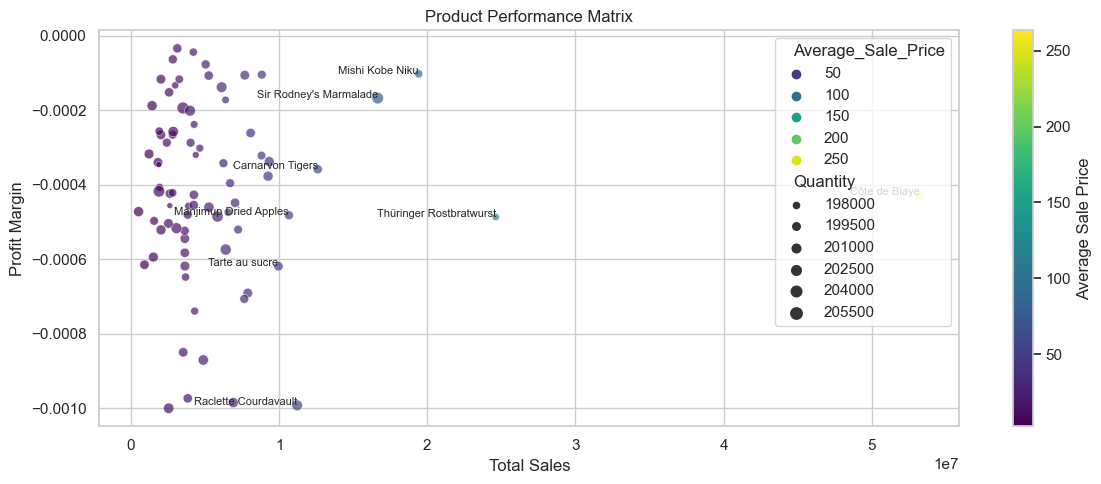

In [104]:
# Calculate additional metrics
product_performance = merged_data.groupby('ProductName').agg({
    'TotalSales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum'
}).reset_index()

product_performance['Profit_Margin'] = product_performance['Profit'] / product_performance['TotalSales']
product_performance['Average_Sale_Price'] = product_performance['TotalSales'] / product_performance['Quantity']

plt.figure(figsize=(12, 5))

# Create scatter plot with contextual information
scatter = sns.scatterplot(data=product_performance, x='TotalSales', y='Profit_Margin', 
                          size='Quantity', hue='Average_Sale_Price', palette='viridis', legend='brief', alpha=0.7)

# Add color bar for Average Sale Price
norm = plt.Normalize(product_performance['Average_Sale_Price'].min(), product_performance['Average_Sale_Price'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Average Sale Price')

# Annotate top products
for i in range(len(product_performance)):
    if product_performance['TotalSales'].iloc[i] > product_performance['TotalSales'].quantile(0.9):
        plt.text(product_performance['TotalSales'].iloc[i], product_performance['Profit_Margin'].iloc[i], 
                 product_performance['ProductName'].iloc[i], fontsize=8, ha='right')

plt.title('Product Performance Matrix')
plt.xlabel('Total Sales')
plt.ylabel('Profit Margin')
plt.grid(True)
plt.tight_layout()
plt.show();

In [105]:
merged_data.head()

OrderID  ProductID  UnitPrice_x  Quantity  Discount  \
0    10248         11         14.0        12       0.0   
1    10248         42          9.8        10       0.0   
2    10248         72         34.8         5       0.0   
3    10296         11         16.8        12       0.0   
4    10296         16         13.9        30       0.0   

                     ProductName  SupplierID  CategoryID   QuantityPerUnit  \
0                 Queso Cabrales           5           4         1 kg pkg.   
1  Singaporean Hokkien Fried Mee          20           5   32 - 1 kg pkgs.   
2         Mozzarella di Giovanni          14           4  24 - 200 g pkgs.   
3                 Queso Cabrales           5           4         1 kg pkg.   
4                        Pavlova           7           3  32 - 500 g boxes   

   UnitPrice_y  ...  ShipVia  Freight                   ShipName  \
0        21.00  ...        3    16.75  Vins et alcools Chevalier   
1        14.00  ...        3    16.75  Vins et alcools Chevalier   
2        34.80  ...        3    16.75  Vins et alcools Chevalier   
3        21.00  ...        1    24.25          LILA-Supermercado   
4        17.45  ...        1    24.25          LILA-Supermercado   

                                      ShipAddress      ShipCity  \
0                              59 rue de l-Abbaye         Reims   
1                              59 rue de l-Abbaye         Reims   
2                              59 rue de l-Abbaye         Reims   
3  Carrera 52 con Ave. Bolívar #65-98 Llano Largo  Barquisimeto   
4  Carrera 52 con Ave. Bolívar #65-98 Llano Largo  Barquisimeto   

       ShipRegion ShipPostalCode ShipCountry TotalSales  Profit  
0  Western Europe          51100      France      168.0   -84.0  
1  Western Europe          51100      France       98.0   -42.0  
2  Western Europe          51100      France      174.0     0.0  
3   South America           3508   Venezuela      201.6   -50.4  
4   South America           3508   Venezuela      417.0  -106.5  

[5 rows x 29 columns]

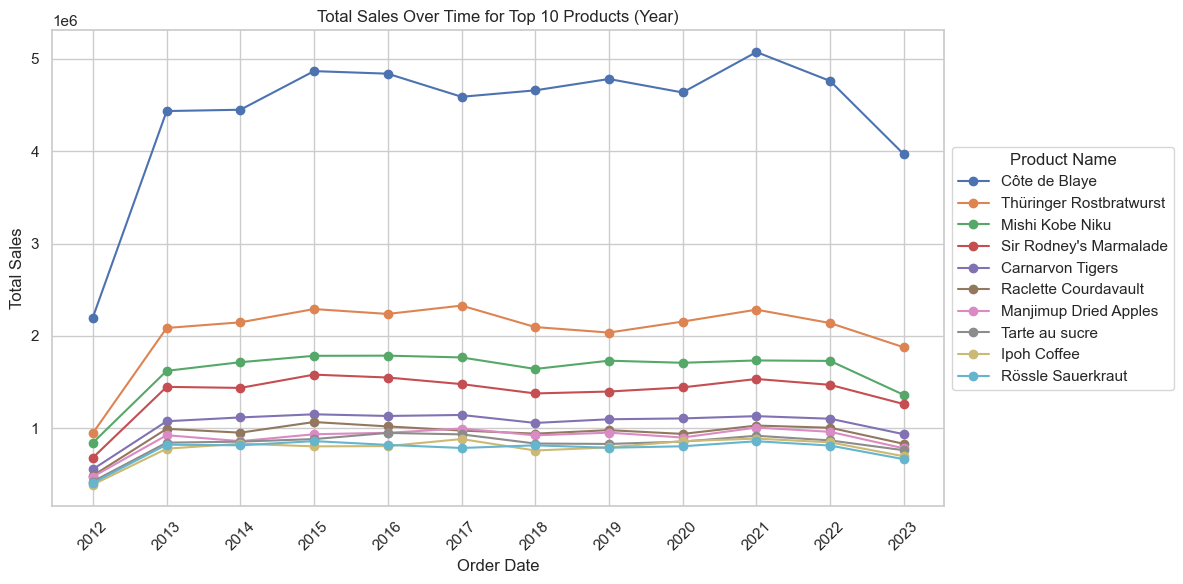

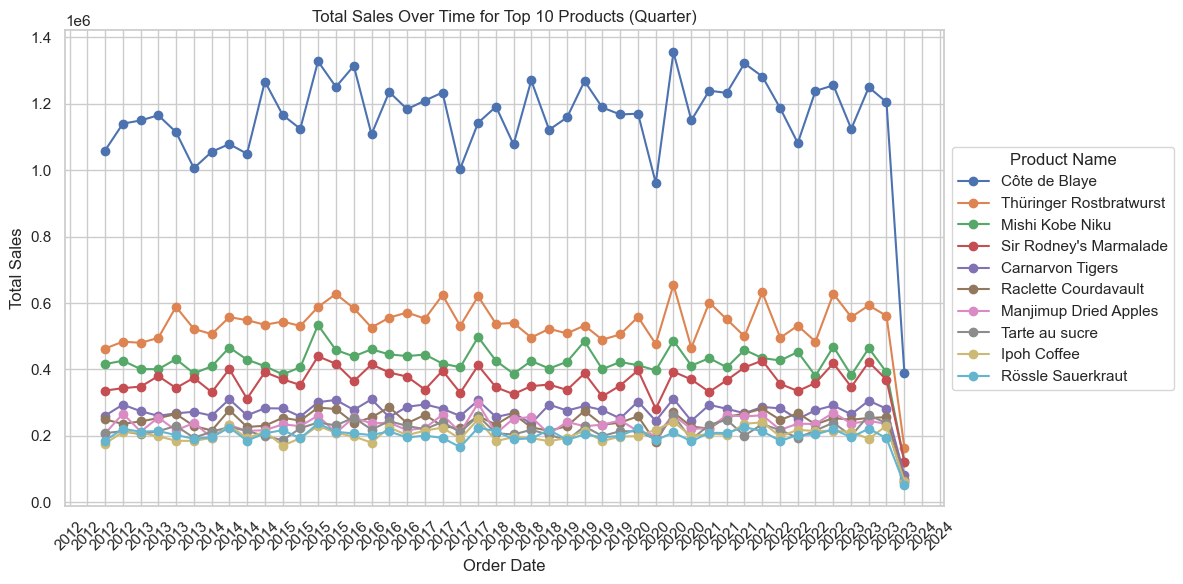

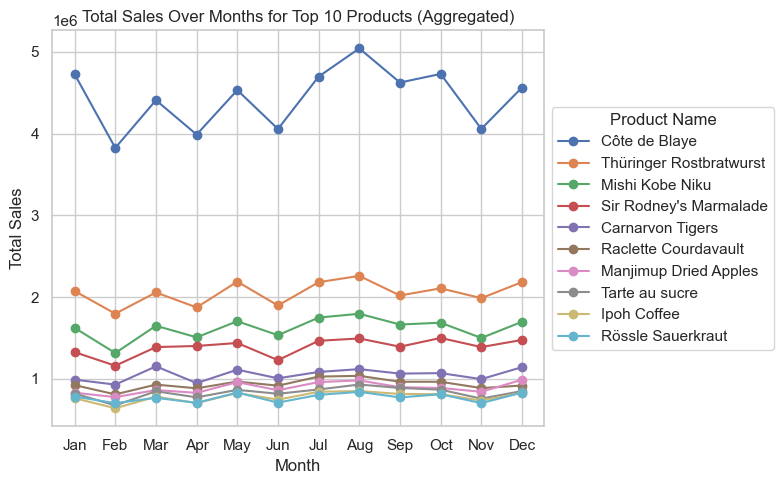

In [106]:
# Convert 'OrderDate' to datetime
merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], format='mixed')

# Identify the top 10 products based on 'TotalSales'
top_products = merged_data.groupby('ProductID')['TotalSales'].sum().nlargest(10).reset_index()

# Merge to get product names
top_products = top_products.merge(merged_data[['ProductID', 'ProductName']].drop_duplicates(), on='ProductID')

# Function to aggregate data by different time periods
def aggregate_by_period(data, period):
    if period == 'year':
        data['Period'] = data['OrderDate'].dt.to_period('Y')
    elif period == 'quarter':
        data['Period'] = data['OrderDate'].dt.to_period('Q')
    else:  # month
        data['Period'] = data['OrderDate'].dt.to_period('M')
    
    return data.groupby(['Period', 'ProductID'])['TotalSales'].sum().reset_index()

# Plot function for yearly and quarterly data
def plot_order_frequency(period='year'):
    order_timing = merged_data[merged_data['ProductID'].isin(top_products['ProductID'])]
    order_timing = aggregate_by_period(order_timing, period)
    
    # Convert 'Period' to datetime for proper plotting
    order_timing['Period'] = order_timing['Period'].dt.to_timestamp()

    plt.figure(figsize=(12, 6))

    # Plot for each of the top products
    for _, row in top_products.iterrows():
        product_data = order_timing[order_timing['ProductID'] == row['ProductID']]
        plt.plot(product_data['Period'], product_data['TotalSales'], label=row['ProductName'], marker='o')

    plt.title(f'Total Sales Over Time for Top 10 Products ({period.capitalize()})')
    plt.xlabel('Order Date')
    plt.ylabel('Total Sales')
    plt.legend(title='Product Name', loc='center left', bbox_to_anchor=(1, 0.5))

    # Set x-axis format based on the period
    if period == 'year':
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    elif period == 'quarter':
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    else:  # month
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function to aggregate data by month irrespective of the year
def aggregate_by_month(data):
    data['Month'] = data['OrderDate'].dt.month
    return data.groupby(['Month', 'ProductID'])['TotalSales'].sum().reset_index()

# Plot function for monthly aggregation irrespective of the year
def plot_order_frequency_by_month():
    order_timing = merged_data[merged_data['ProductID'].isin(top_products['ProductID'])]
    order_timing = aggregate_by_month(order_timing)
    
    plt.figure(figsize=(8, 5))

    # Plot for each of the top products
    for _, row in top_products.iterrows():
        product_data = order_timing[order_timing['ProductID'] == row['ProductID']]
        plt.plot(product_data['Month'], product_data['TotalSales'], label=row['ProductName'], marker='o')

    plt.title(f'Total Sales Over Months for Top 10 Products (Aggregated)')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.legend(title='Product Name', loc='center left', bbox_to_anchor=(1, 0.5))

    # Set x-axis labels as months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.tight_layout()
    plt.show()

# Call the plot functions
plot_order_frequency('year')    # Yearly plot
plot_order_frequency('quarter') # Quarterly plot
plot_order_frequency_by_month() # Monthly aggregated plot

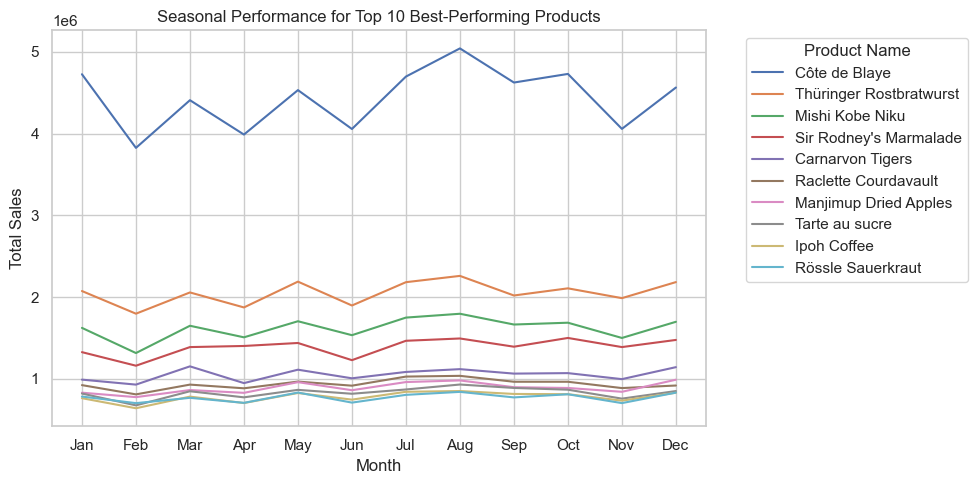

In [107]:
# Seasonal Performance

# Select the top 10 best-performing products based on TotalSales
top_products = product_performance.sort_values('TotalSales', ascending=False).head(10)['ProductName'].tolist()

# Extract the month from the OrderDate
merged_data['Month'] = merged_data['OrderDate'].dt.month

# Group the data by Month and ProductName to calculate TotalSales
seasonal_performance = merged_data.groupby(['Month', 'ProductName'])['TotalSales'].sum().reset_index()

# Plot the seasonal performance for the top 10 products
plt.figure(figsize=(10, 5))
for product in top_products:
    product_data = seasonal_performance[seasonal_performance['ProductName'] == product]
    plt.plot(product_data['Month'], product_data['TotalSales'], label=product)

plt.title('Seasonal Performance for Top 10 Best-Performing Products')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Product Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show();

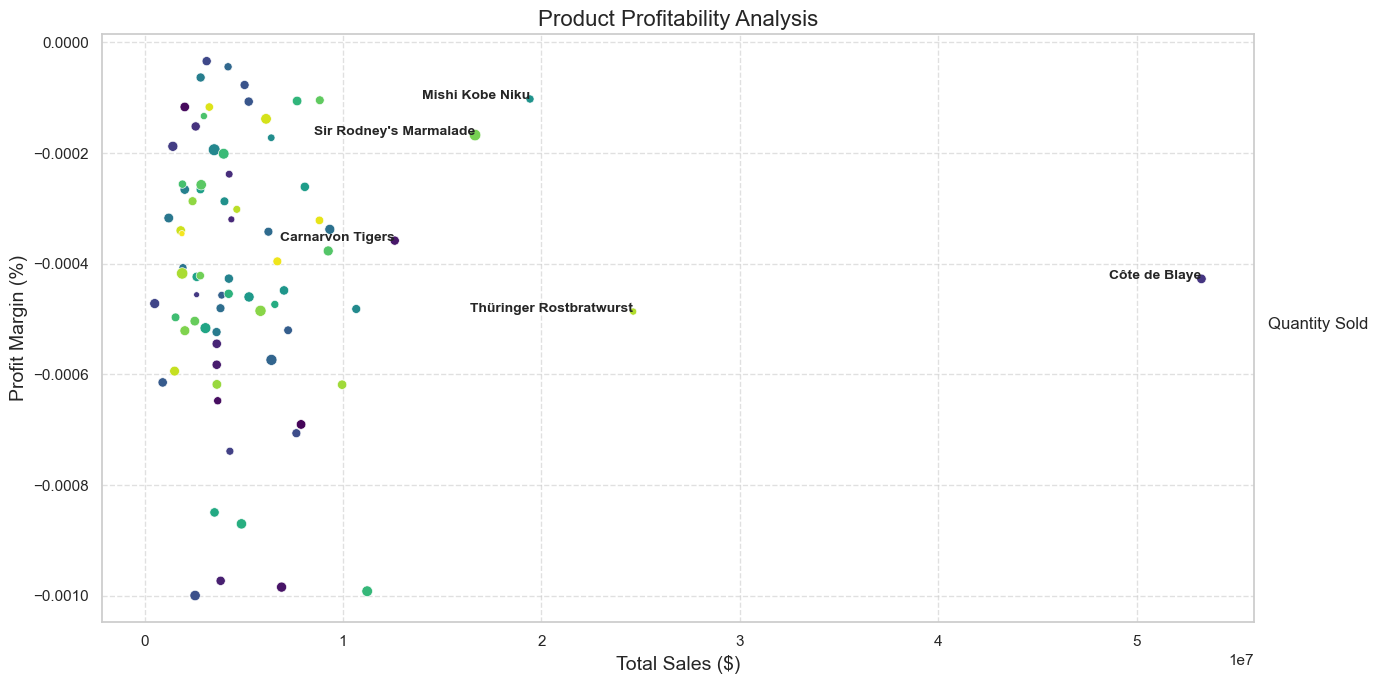

In [108]:
# Profitability Analysis
profitability = merged_data.groupby('ProductName').agg({
    'TotalSales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum'
}).reset_index()
profitability['Profit_Margin'] = profitability['Profit'] / profitability['TotalSales']

# Plot profitability with enhanced context
plt.figure(figsize=(14, 7))
sns.scatterplot(data=profitability, x='TotalSales', y='Profit_Margin', size='Quantity', hue='ProductName', palette='viridis', legend=False)

plt.title('Product Profitability Analysis', fontsize=16)
plt.xlabel('Total Sales ($)', fontsize=14)
plt.ylabel('Profit Margin (%)', fontsize=14)

# Annotate the top 5 products by TotalSales
top_products = profitability.sort_values('TotalSales', ascending=False).head(5)
for i in range(top_products.shape[0]):
    plt.text(top_products['TotalSales'].iloc[i], 
             top_products['Profit_Margin'].iloc[i], 
             top_products['ProductName'].iloc[i], 
             fontsize=10, 
             weight='bold', 
             ha='right')

# Adding a legend for Quantity
handles, labels = plt.gca().get_legend_handles_labels()
sizes = [float(label) for label in labels]  # Convert labels to float for sorting
order = np.argsort(sizes)[::-1]  # Sort in descending order
handles = [handles[idx] for idx in order]
labels = [labels[idx] for idx in order]
plt.legend(handles, labels, title='Quantity Sold', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show();

In [110]:
# 7. Customer Retention Analysis
customer_orders = merged_data.groupby(['CustomerID', 'OrderDate'])['OrderID'].first().reset_index()
customer_orders['OrderNumber'] = customer_orders.groupby('CustomerID').cumcount() + 1

repeat_customers = customer_orders[customer_orders['OrderNumber'] > 1]['CustomerID'].nunique()
total_customers = customer_orders['CustomerID'].nunique()
retention_rate = repeat_customers / total_customers

print(f"Customer Retention Rate: {retention_rate:.2%}")

Customer Retention Rate: 100.00%


# QUESTION 3
## Order Trends: Evaluate order trends over time, including the impact of promotions and external events

In [111]:
orderFrequencyData = shippingPreferenceData.copy()

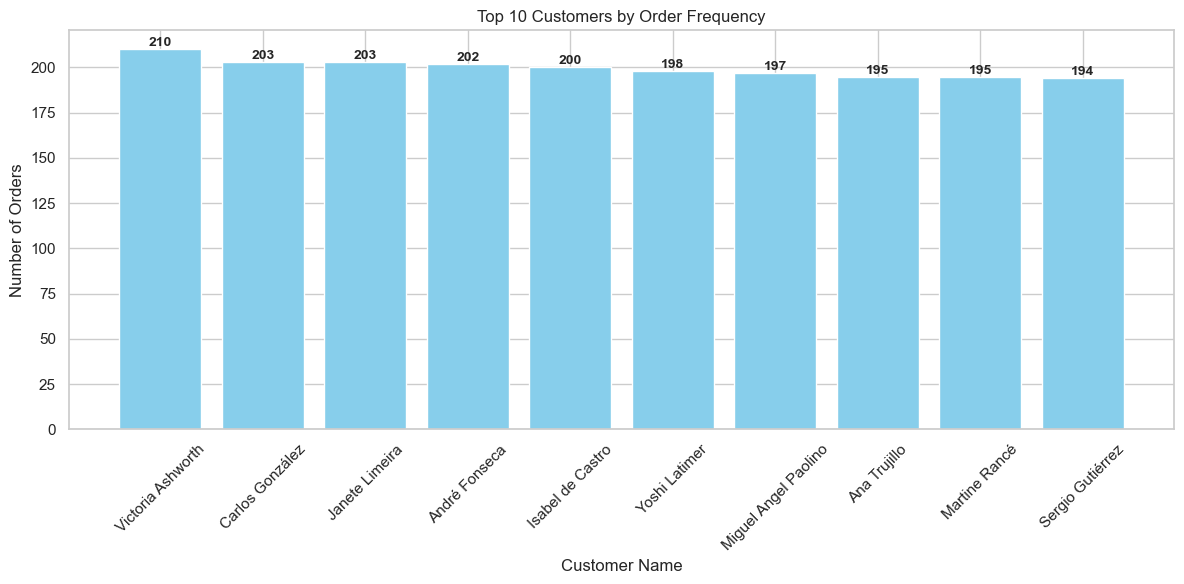

In [112]:
top_customers = orderFrequencyData['CustomerID'].value_counts().head(10).reset_index()
top_customers.columns = ['CustomerID', 'OrderCount']

top_customers = top_customers.merge(customers[['CustomerID', 'ContactName']], on='CustomerID')

plt.figure(figsize=(12, 6))
bars = plt.bar(top_customers['ContactName'], top_customers['OrderCount'], color='skyblue')

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Top 10 Customers by Order Frequency')
plt.xlabel('Customer Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

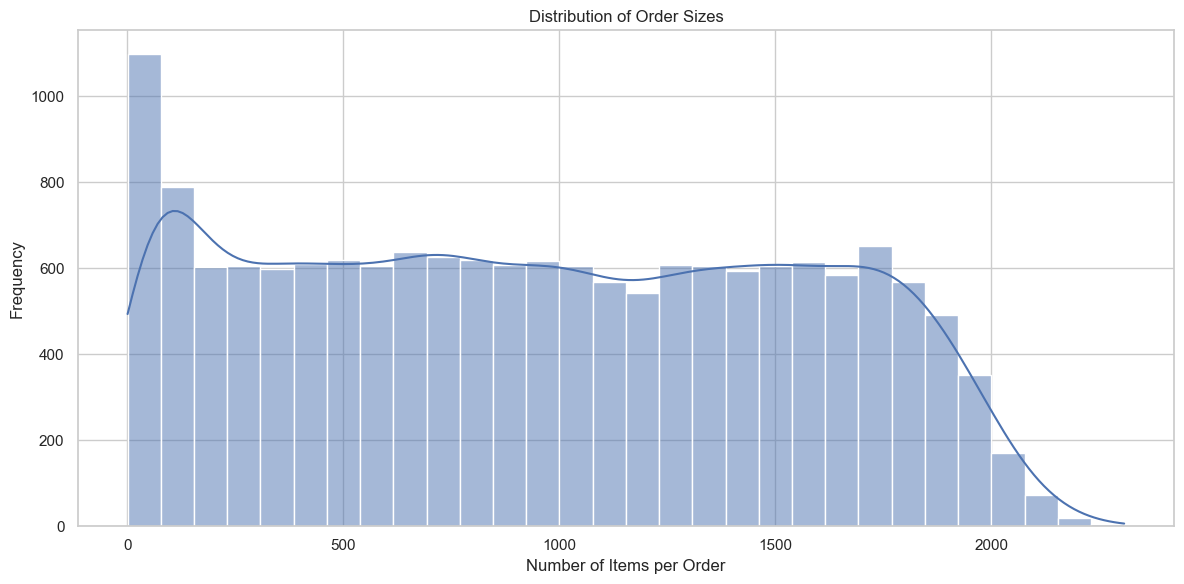

In [139]:
# Order Size Distribution
order_sizes = merged_data.groupby('OrderID')['Quantity'].sum()

plt.figure(figsize=(12, 6))
sns.histplot(order_sizes, bins=30, kde=True)
plt.title('Distribution of Order Sizes')
plt.xlabel('Number of Items per Order')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

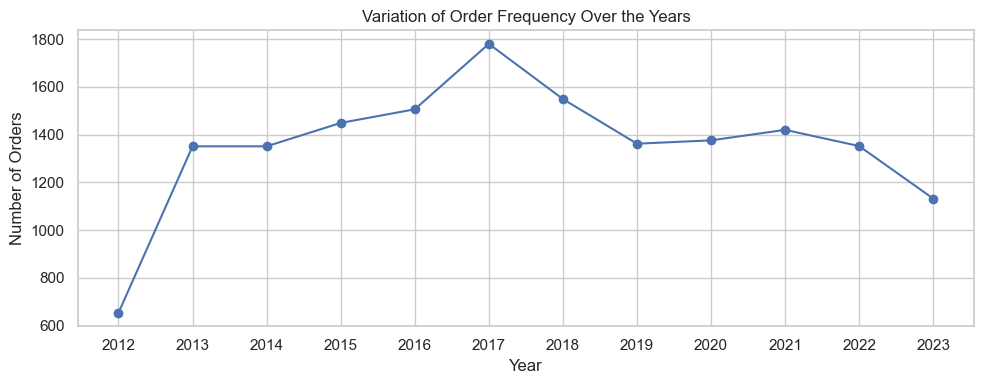

In [140]:
# Yearly Order Frequency Analysis
# Convert 'OrderDate' to datetime
merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], format='mixed')

# Aggregate data by year
yearly_orders = merged_data.groupby(merged_data['OrderDate'].dt.year)['OrderID'].nunique().reset_index()
yearly_orders.columns = ['Year', 'Number of Orders']

# Plot yearly order variation
plt.figure(figsize=(10, 4))
plt.plot(yearly_orders['Year'], yearly_orders['Number of Orders'], marker='o')
plt.title('Variation of Order Frequency Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Orders')
plt.xticks(yearly_orders['Year'])
plt.tight_layout()
plt.show();

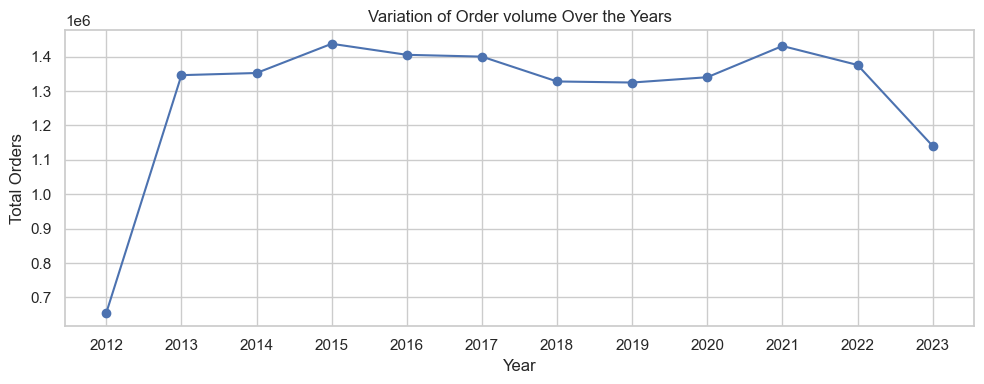

In [114]:
# Yearly Order Volume Analysis
# Convert 'OrderDate' to datetime
merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], format='mixed')

# Aggregate data by year
yearly_orders = merged_data.groupby(merged_data['OrderDate'].dt.year)['Quantity'].sum().reset_index()
yearly_orders.columns = ['Year', 'Total Orders']

# Plot yearly order variation
plt.figure(figsize=(10, 4))
plt.plot(yearly_orders['Year'], yearly_orders['Total Orders'], marker='o')
plt.title('Variation of Order volume Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Orders')
plt.xticks(yearly_orders['Year'])
plt.tight_layout()
plt.show();

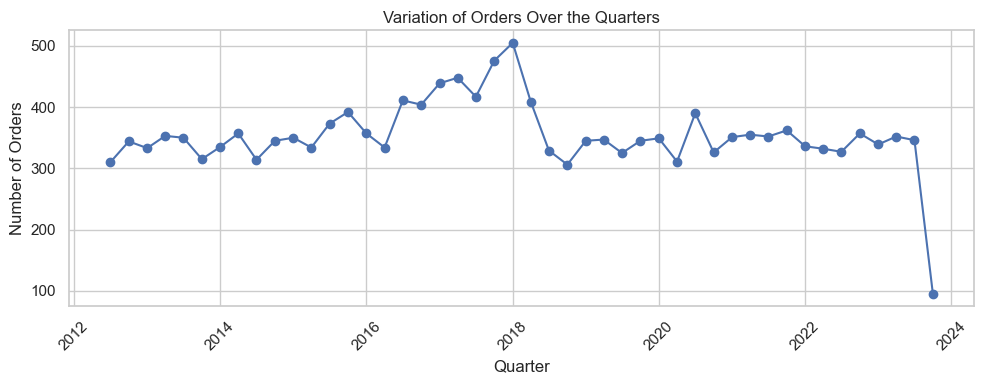

In [115]:
# Quarterly Order Frequency Analysis
# Aggregate data by quarter
quarterly_orders = merged_data.groupby(merged_data['OrderDate'].dt.to_period('Q'))['OrderID'].nunique().reset_index()

# Convert 'Period' to datetime for proper plotting
quarterly_orders['OrderDate'] = quarterly_orders['OrderDate'].dt.to_timestamp()

# Plot quarterly order variation
plt.figure(figsize=(10, 4))
plt.plot(quarterly_orders['OrderDate'], quarterly_orders['OrderID'], marker='o')
plt.title('Variation of Orders Over the Quarters')
plt.xlabel('Quarter')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

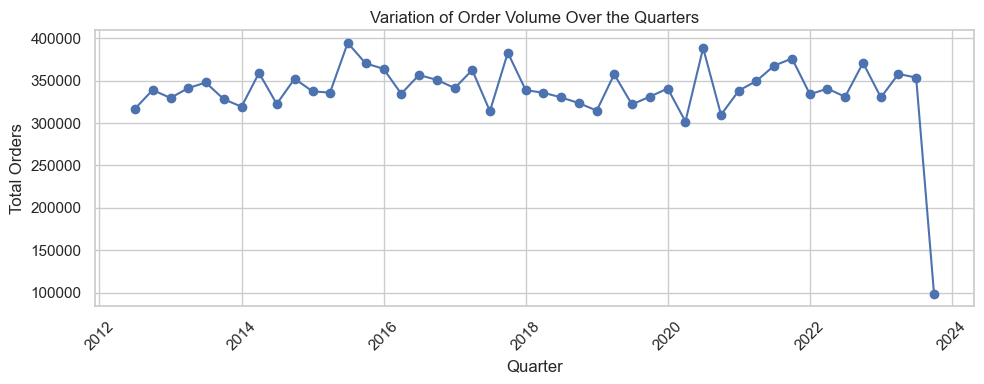

In [116]:
# Quarterly Order Volume Analysis
quarterly_orders = merged_data.groupby(merged_data['OrderDate'].dt.to_period('Q'))['Quantity'].sum().reset_index()

# Convert 'Period' to datetime for proper plotting
quarterly_orders['OrderDate'] = quarterly_orders['OrderDate'].dt.to_timestamp()

# Plot quarterly order variation
plt.figure(figsize=(10, 4))
plt.plot(quarterly_orders['OrderDate'], quarterly_orders['Quantity'], marker='o')
plt.title('Variation of Order Volume Over the Quarters')
plt.xlabel('Quarter')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

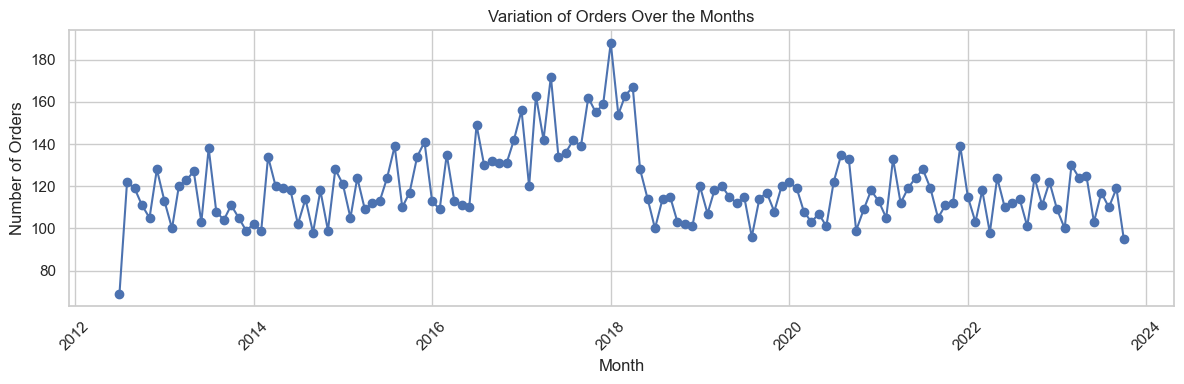

In [117]:
# Aggregate data by month
monthly_orders = merged_data.groupby(merged_data['OrderDate'].dt.to_period('M'))['OrderID'].nunique().reset_index()

# Convert 'Period' to datetime for proper plotting
monthly_orders['OrderDate'] = monthly_orders['OrderDate'].dt.to_timestamp()

# Plot monthly order variation
plt.figure(figsize=(12, 4))
plt.plot(monthly_orders['OrderDate'], monthly_orders['OrderID'], marker='o')
plt.title('Variation of Orders Over the Months')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

In [118]:
yearly_orders.head()

Year  Total Orders
0  2012        655344
1  2013       1346377
2  2014       1352623
3  2015       1437596
4  2016       1405527

In [119]:
quarterly_orders.head()

OrderDate  Quantity
0 2012-07-01    316530
1 2012-10-01    338814
2 2013-01-01    329532
3 2013-04-01    340978
4 2013-07-01    347704

In [120]:
monthly_orders.head()

OrderDate  OrderID
0 2012-07-01       69
1 2012-08-01      122
2 2012-09-01      119
3 2012-10-01      111
4 2012-11-01      105

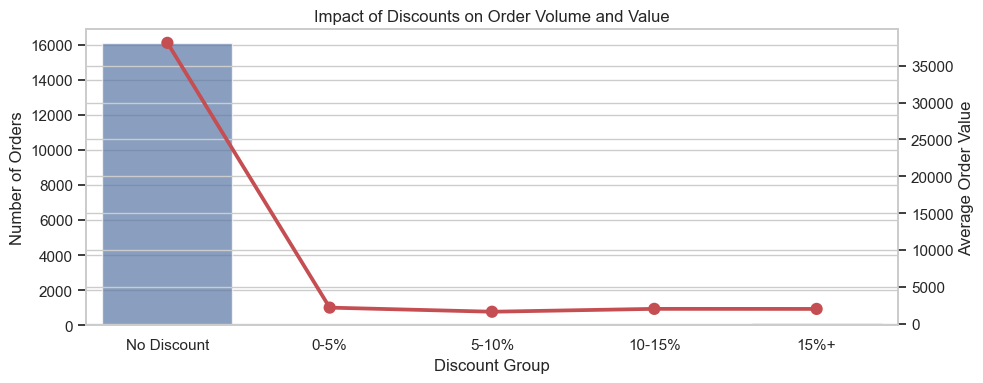

In [144]:
# Discount Impact Analysis

# Calculate OrderValue as the sum of discountedTotal for each order
merged_data['OrderValue'] = merged_data.groupby('OrderID')['TotalSales'].transform('sum')

# Create DiscountGroup based on the discount percentage
merged_data['DiscountGroup'] = pd.cut(merged_data['Discount'], bins=[-0.01, 0, 0.05, 0.1, 0.15, 1], labels=['No Discount', '0-5%', '5-10%', '10-15%', '15%+'])

# Group by DiscountGroup to analyze impact
discount_impact = merged_data.groupby('DiscountGroup').agg({
    'OrderID': 'nunique',
    'OrderValue': 'mean'
}).reset_index()

# Plotting the impact of discounts
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

sns.barplot(x='DiscountGroup', y='OrderID', data=discount_impact, ax=ax1, alpha=0.7)
sns.pointplot(x='DiscountGroup', y='OrderValue', data=discount_impact, ax=ax2, color='r')

ax1.set_xlabel('Discount Group')
ax1.set_ylabel('Number of Orders')
ax2.set_ylabel('Average Order Value')

plt.title('Impact of Discounts on Order Volume and Value')
plt.tight_layout()
plt.show();

# QUESTION 4
## Supplier Analysis: Assess the performance and reliability of suppliers based on delivery times, product quality, and order fulfillment rates

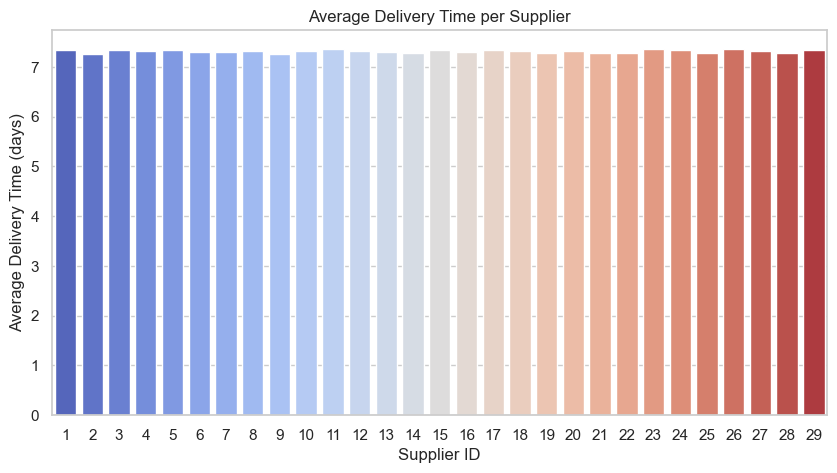

In [145]:
# Ensure both 'OrderDate' and 'ShippedDate' are in datetime format
if not pd.api.types.is_datetime64_any_dtype(merged_data['OrderDate']):
    merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], format='mixed')

if not pd.api.types.is_datetime64_any_dtype(merged_data['ShippedDate']):
    merged_data['ShippedDate'] = pd.to_datetime(merged_data['ShippedDate'], format='mixed')

# Calculate delivery time in days
merged_data['DeliveryTime'] = (merged_data['ShippedDate'] - merged_data['OrderDate']).dt.days

# Average delivery time per supplier
avg_delivery_time_per_supplier = merged_data.groupby('SupplierID')['DeliveryTime'].mean().reset_index()

# Plotting average delivery time
plt.figure(figsize=(10, 5))
sns.barplot(x='SupplierID', y='DeliveryTime', data=avg_delivery_time_per_supplier, palette='coolwarm')
plt.title('Average Delivery Time per Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('Average Delivery Time (days)')
plt.show();

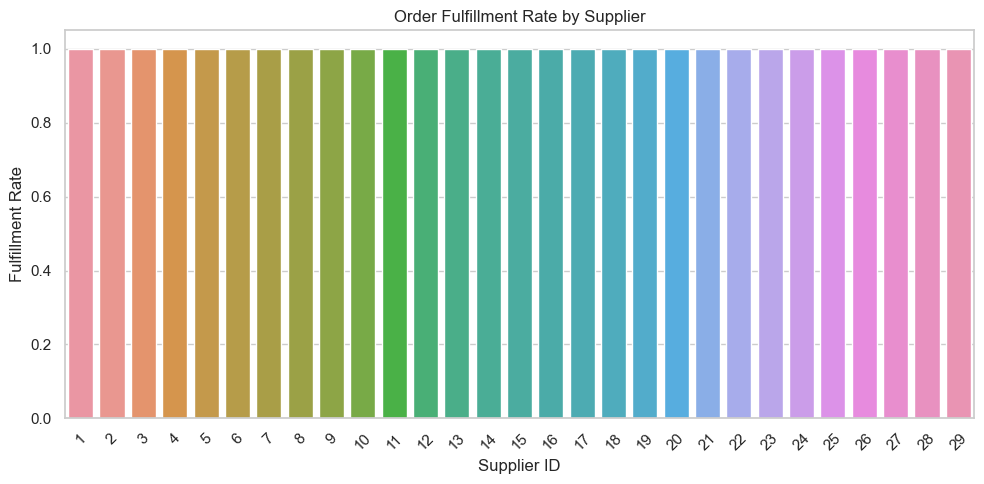

In [146]:
# Order Fulfillment Rate
# Assuming merged_data is the DataFrame containing the merged information
merged_data['Fulfilled'] = merged_data['ShippedDate'].notna()
fulfillment_rate = merged_data.groupby('SupplierID')['Fulfilled'].mean().reset_index()

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='SupplierID', y='Fulfilled', data=fulfillment_rate, order=fulfillment_rate['SupplierID'])
plt.title('Order Fulfillment Rate by Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('Fulfillment Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

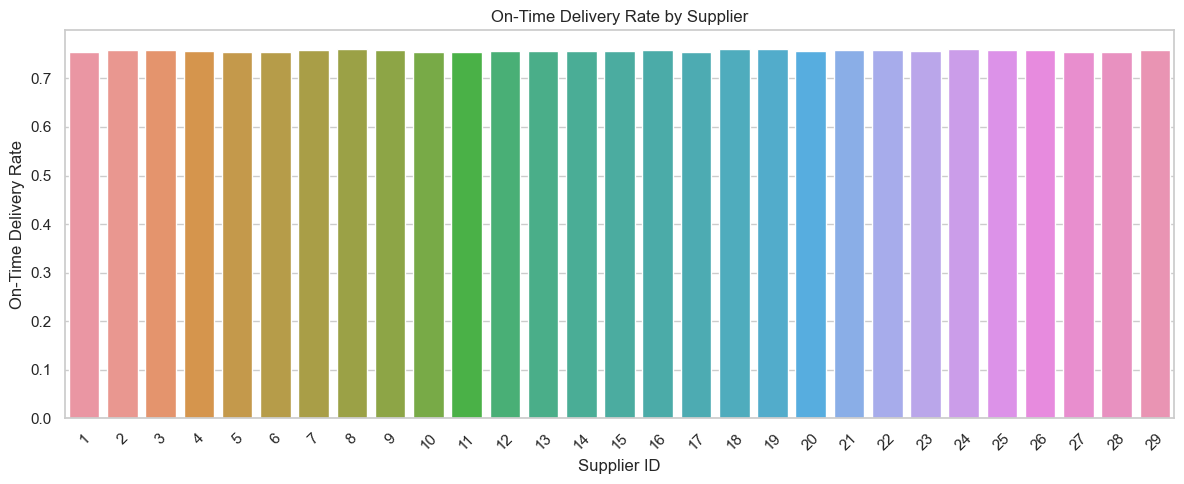

In [147]:
# On-Time Delivery Rate
merged_data['OnTime'] = merged_data['ShippedDate'] <= merged_data['RequiredDate']
on_time_delivery_rate = merged_data.groupby('SupplierID')['OnTime'].mean().reset_index()

# Visualization
plt.figure(figsize=(12, 5))
sns.barplot(x='SupplierID', y='OnTime', data=on_time_delivery_rate, order=on_time_delivery_rate['SupplierID'])
plt.title('On-Time Delivery Rate by Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('On-Time Delivery Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

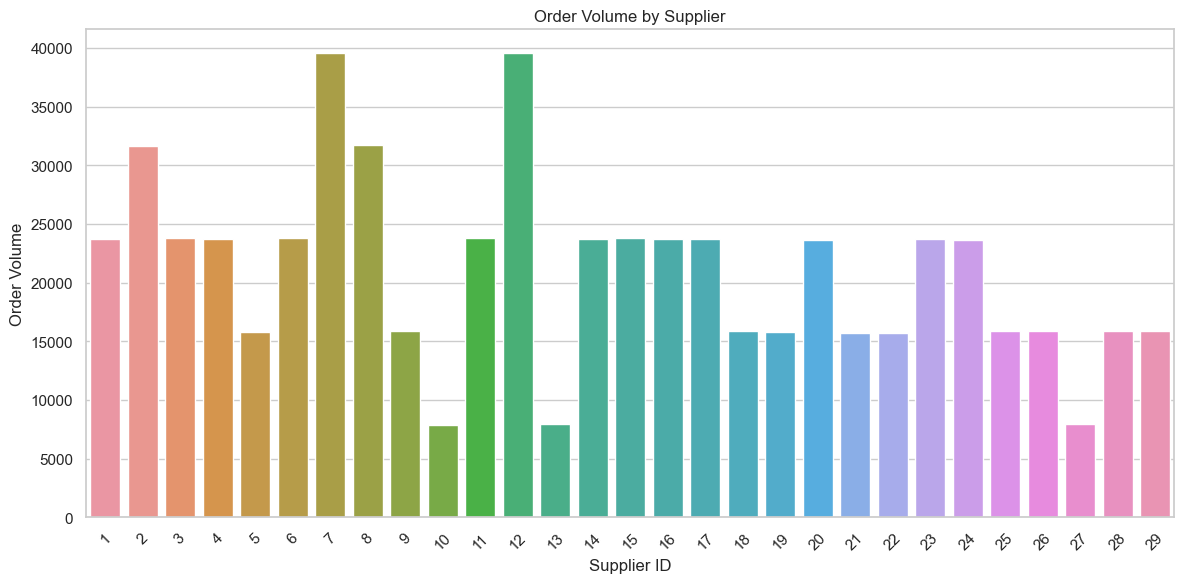

In [148]:
# Order Volumne by Supplier
order_volume = merged_data.groupby('SupplierID')['OrderID'].count().reset_index()

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='SupplierID', y='OrderID', data=order_volume, order=order_volume['SupplierID'])
plt.title('Order Volume by Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('Order Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

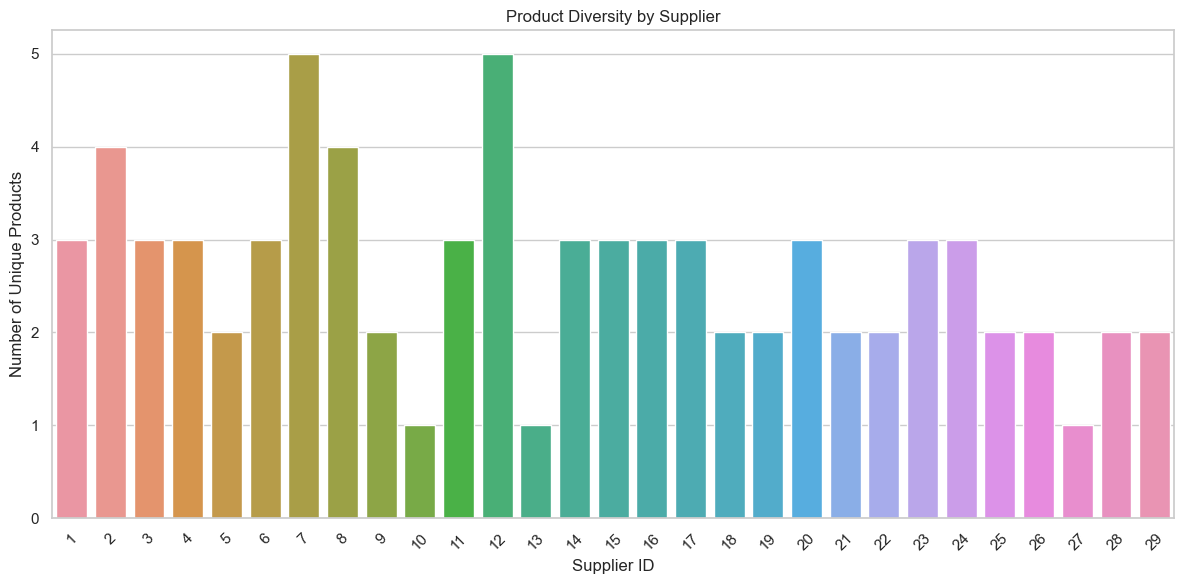

In [149]:
# Product Diversity
product_diversity = merged_data.groupby('SupplierID')['ProductID'].nunique().reset_index()

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='SupplierID', y='ProductID', data=product_diversity, order=product_diversity['SupplierID'])
plt.title('Product Diversity by Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('Number of Unique Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

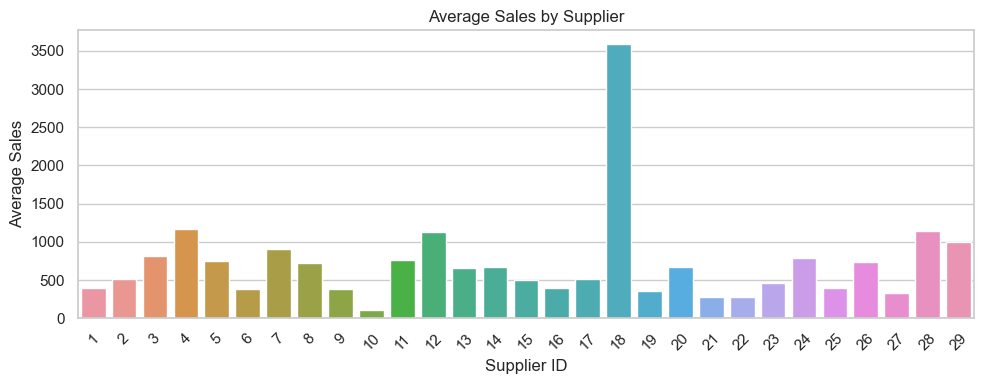

In [150]:
# Calculate average order value by supplier
average_order_value = merged_data.groupby('SupplierID')['TotalSales'].mean().reset_index()

# Visualization
plt.figure(figsize=(10, 4))
sns.barplot(x='SupplierID', y='TotalSales', data=average_order_value, order=average_order_value['SupplierID'])
plt.title('Average Sales by Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

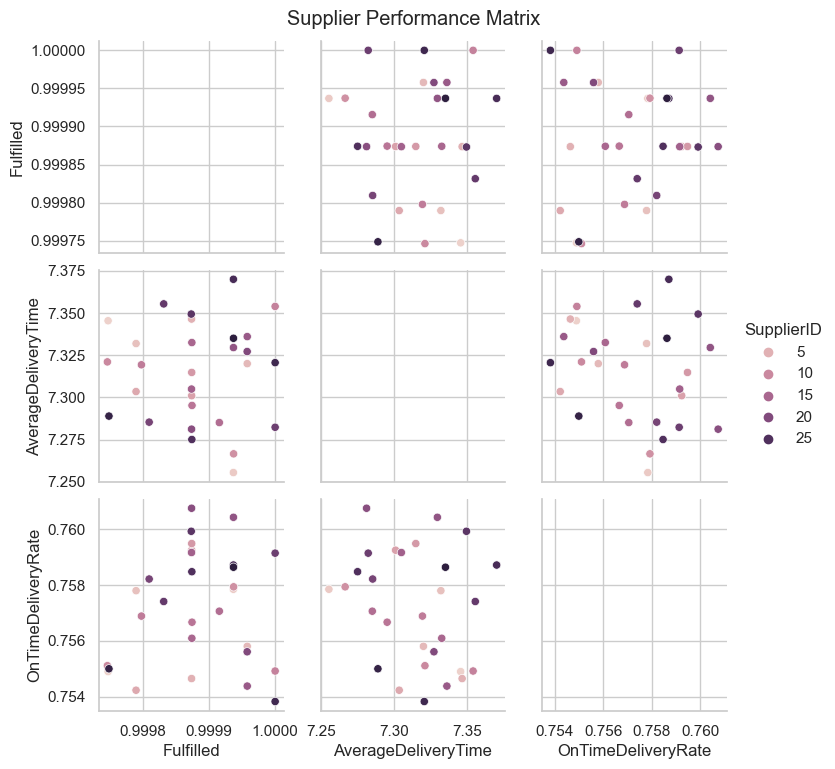

In [151]:
# Supplier Performance Matrix
# Combine key metrics into a DataFrame for the matrix
performance_matrix = fulfillment_rate.copy()
performance_matrix['AverageDeliveryTime'] = avg_delivery_time_per_supplier['DeliveryTime']
performance_matrix['OnTimeDeliveryRate'] = on_time_delivery_rate['OnTime']

# Visualization
sns.pairplot(performance_matrix, hue='SupplierID')
plt.suptitle('Supplier Performance Matrix', y=1.02)
plt.show();

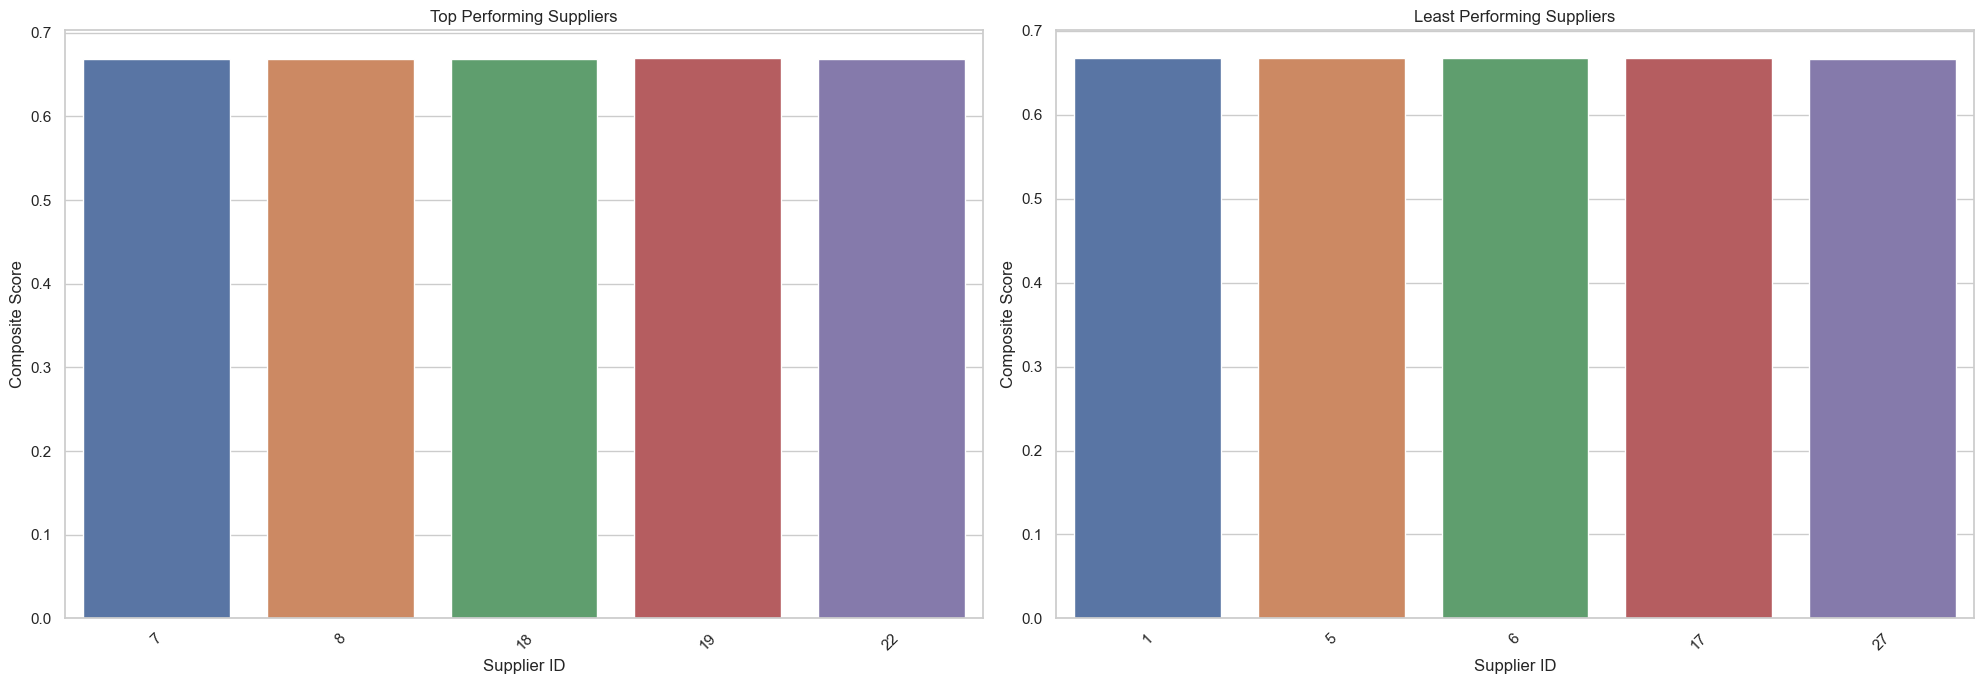

In [153]:
# Top and Bottom Performing Supplier
# Calculate a composite score (you can adjust weights based on importance)
performance_matrix['CompositeScore'] = (
    0.4 * performance_matrix['Fulfilled'] +
    0.3 * (1 / performance_matrix['AverageDeliveryTime']) +  # Shorter times are better
    0.3 * performance_matrix['OnTimeDeliveryRate']
)

# Sort and identify top and bottom performers
top_suppliers = performance_matrix.sort_values(by='CompositeScore', ascending=False).head(5)
bottom_suppliers = performance_matrix.sort_values(by='CompositeScore', ascending=True).head(5)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Top Performing Suppliers
sns.barplot(ax=axes[0], x='SupplierID', y='CompositeScore', data=top_suppliers)
axes[0].set_title('Top Performing Suppliers')
axes[0].set_xlabel('Supplier ID')
axes[0].set_ylabel('Composite Score')
axes[0].tick_params(axis='x', rotation=45)

# Bottom Performing Suppliers
sns.barplot(ax=axes[1], x='SupplierID', y='CompositeScore', data=bottom_suppliers)
axes[1].set_title('Least Performing Suppliers')
axes[1].set_xlabel('Supplier ID')
axes[1].set_ylabel('Composite Score')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show();

# Question 5: 
## Sales Forecasting: Use time series analysis to forecast future sales and identify potential growth opportunities

In [174]:
merged_data.head()

OrderID  ProductID  UnitPrice_x  Quantity  Discount  \
0    10248         11         14.0        12       0.0   
1    10248         42          9.8        10       0.0   
2    10248         72         34.8         5       0.0   
3    10296         11         16.8        12       0.0   
4    10296         16         13.9        30       0.0   

                     ProductName  SupplierID  CategoryID   QuantityPerUnit  \
0                 Queso Cabrales           5           4         1 kg pkg.   
1  Singaporean Hokkien Fried Mee          20           5   32 - 1 kg pkgs.   
2         Mozzarella di Giovanni          14           4  24 - 200 g pkgs.   
3                 Queso Cabrales           5           4         1 kg pkg.   
4                        Pavlova           7           3  32 - 500 g boxes   

   UnitPrice_y  ...  ShipPostalCode  ShipCountry  TotalSales Profit Month  \
0        21.00  ...           51100       France       168.0  -84.0     7   
1        14.00  ...           51100       France        98.0  -42.0     7   
2        34.80  ...           51100       France       174.0    0.0     7   
3        21.00  ...            3508    Venezuela       201.6  -50.4     9   
4        17.45  ...            3508    Venezuela       417.0 -106.5     9   

   OrderValue DiscountGroup DeliveryTime Fulfilled  OnTime  
0       440.0   No Discount         12.0      True    True  
1       440.0   No Discount         12.0      True    True  
2       440.0   No Discount         12.0      True    True  
3      1050.6   No Discount          8.0      True    True  
4      1050.6   No Discount          8.0      True    True  

[5 rows x 35 columns]

In [175]:
# Merge datasets to get full sales data
sales_data = merged_data.copy()

# Convert 'OrderDate' to datetime
sales_data['OrderDate'] = pd.to_datetime(sales_data['OrderDate'], format='mixed')

# Aggregate sales by month
sales_data['Month'] = sales_data['OrderDate'].dt.to_period('M')
monthly_sales = sales_data.groupby('Month')['TotalSales'].sum().reset_index()

# Aggregate Sales by year
yearly_sales = sales_data.groupby(sales_data['OrderDate'].dt.year)['TotalSales'].sum().reset_index()

# Aggreagate Sales by Quarter
quarterly_sales = sales_data.groupby(sales_data['OrderDate'].dt.to_period('Q'))['TotalSales'].sum().reset_index()
quarterly_sales['OrderDate'] = quarterly_sales['OrderDate'].dt.to_timestamp()

# Set 'Month' as the index for time series analysis
monthly_sales.set_index('Month', inplace=True)

In [176]:
monthly_sales.head()

TotalSales
Month              
2012-07  2066219.40
2012-08  3556875.79
2012-09  3440144.98
2012-10  3201529.96
2012-11  2980494.74

In [177]:
yearly_sales.sort_values(by="TotalSales", ascending=False)

OrderDate    TotalSales
3        2015  4.142346e+07
9        2021  4.135555e+07
4        2016  4.056867e+07
5        2017  4.020990e+07
10       2022  3.974207e+07
2        2014  3.887015e+07
8        2020  3.886244e+07
1        2013  3.863312e+07
7        2019  3.851696e+07
6        2018  3.832662e+07
11       2023  3.305449e+07
0        2012  1.882320e+07

In [178]:
quarterly_sales.head()

OrderDate  TotalSales
0 2012-07-01  9063240.17
1 2012-10-01  9759961.55
2 2013-01-01  9510972.36
3 2013-04-01  9832605.77
4 2013-07-01  9934475.02

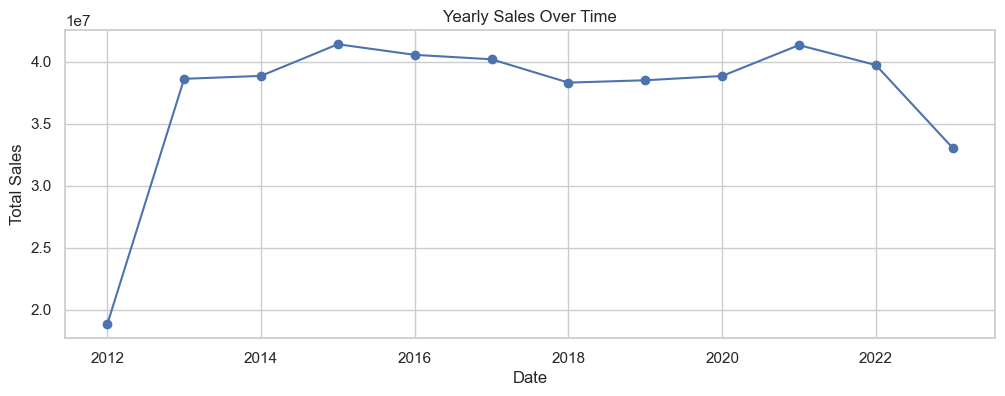

In [179]:
# Plot the aggregated yearly sales data to observe trends, seasonality, and patterns.
plt.figure(figsize=(12, 4))
plt.plot(yearly_sales["OrderDate"], yearly_sales['TotalSales'], marker='o')
plt.title('Yearly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show();

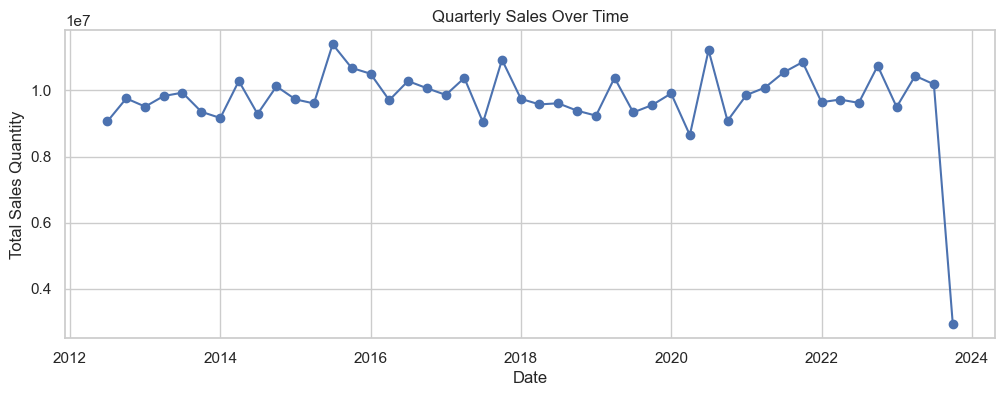

In [180]:
# Plot the aggregated yearly sales data to observe trends, seasonality, and patterns.
plt.figure(figsize=(12, 4))
plt.plot(quarterly_sales["OrderDate"], quarterly_sales['TotalSales'], marker='o')
plt.title('Quarterly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.grid(True)
plt.show();

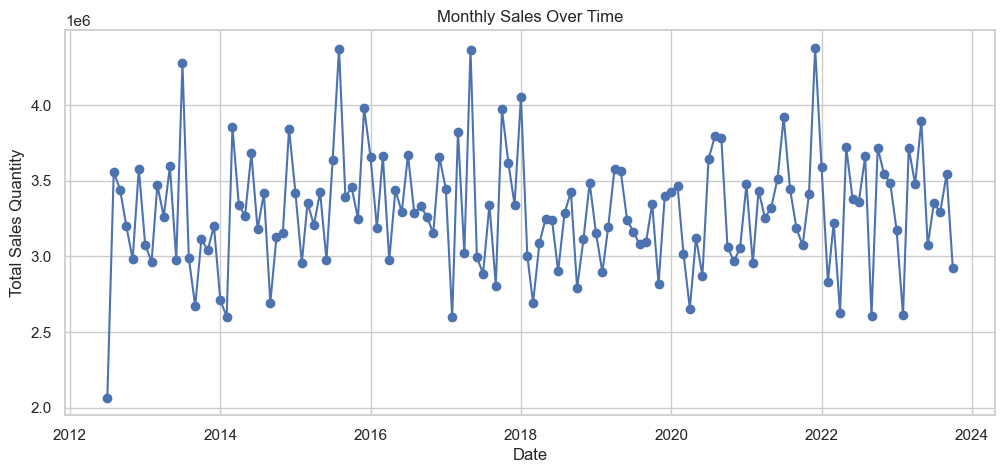

In [181]:
# Plot the aggregated monthly sales data to observe trends, seasonality, and patterns.
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales.index.to_timestamp(), monthly_sales['TotalSales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.grid(True)
plt.show();

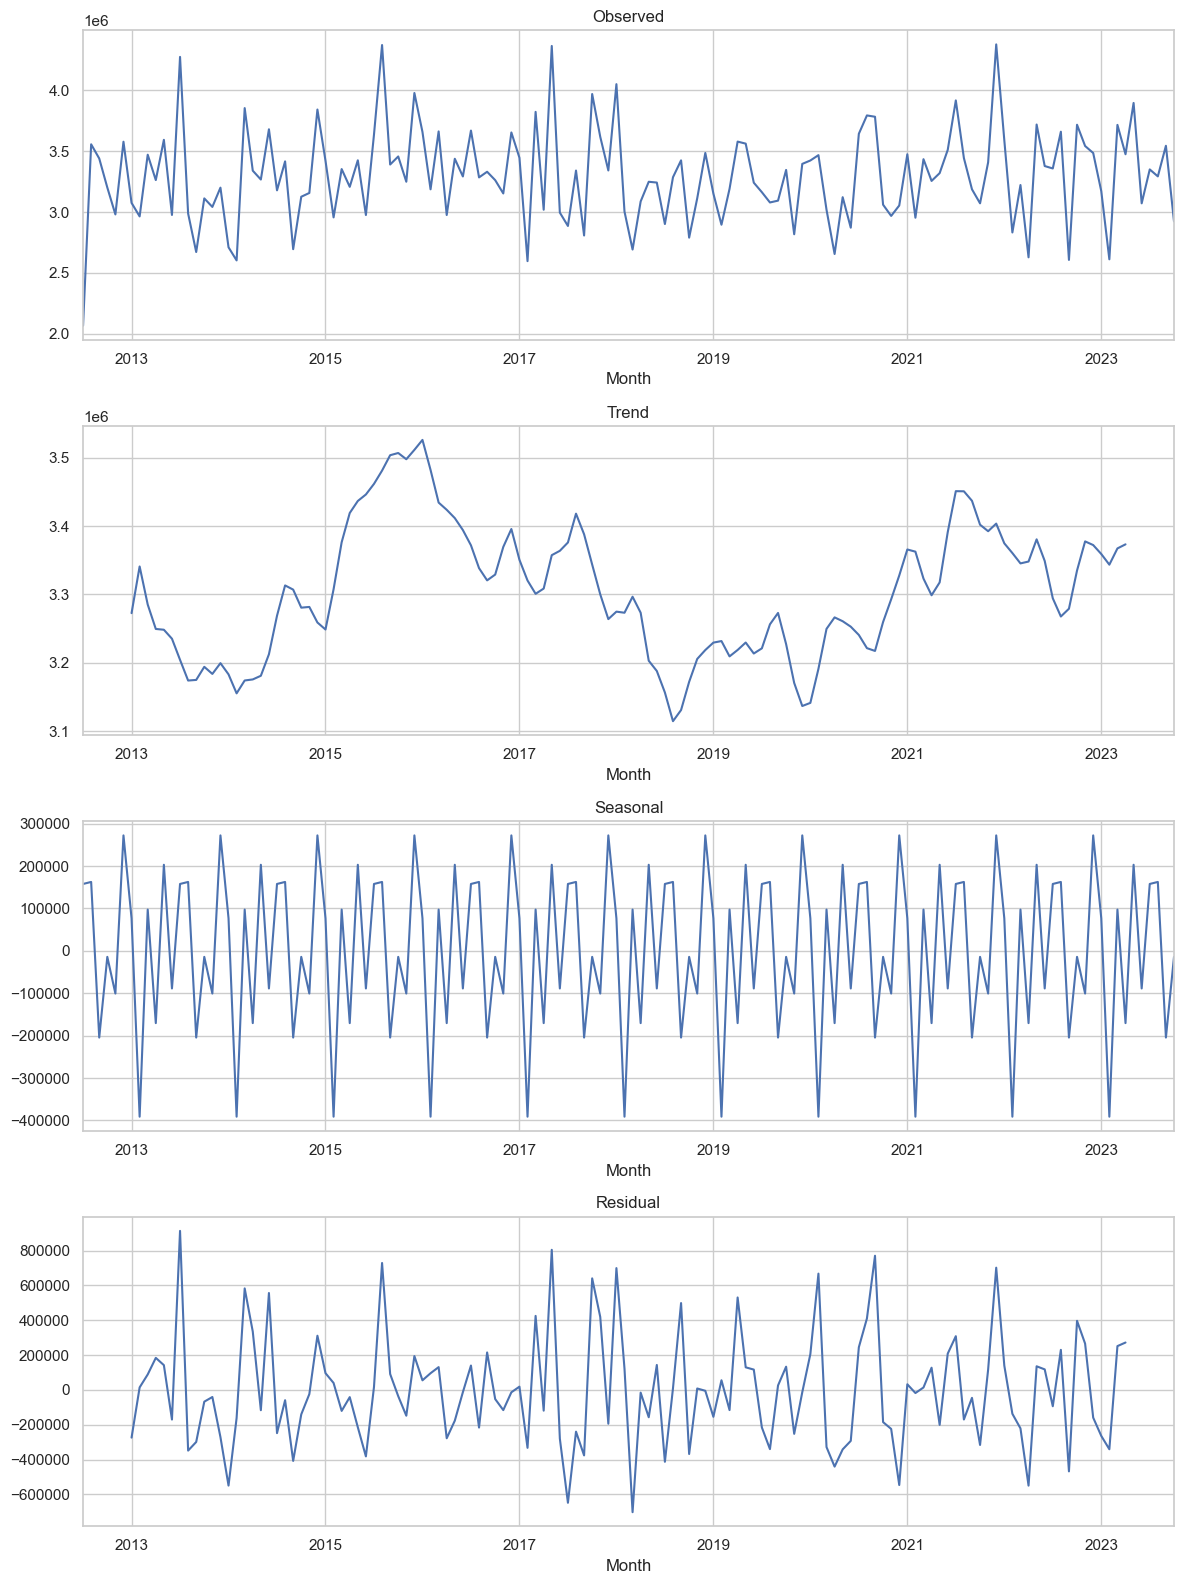

In [182]:
# Decompose the time series into its components: trend, seasonality, and residuals.

# Ensure the index is a DatetimeIndex and set the frequency to 'M' (monthly)
timeseriesData = monthly_sales.copy()
timeseriesData = timeseriesData.asfreq('M')  # Ensure the frequency is set to monthly

# Handle missing values by forward-filling
timeseriesData['TotalSales'] = timeseriesData['TotalSales'].ffill()

# Ensure the time series is sufficiently long for decomposition
if len(timeseriesData) < 2:
    raise ValueError("Time series is too short for decomposition")

# Decompose the time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(timeseriesData['TotalSales'], model='additive', period=12)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')

plt.tight_layout()
plt.show();

In [183]:
# Stationarity Check and Differencing
# Check if the time series is stationary using the Augmented Dickey-Fuller (ADF) test.
# Apply differencing to remove trends and seasonality if needed.

# ADF test
adf_test = adfuller(timeseriesData['TotalSales'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Differencing if necessary (for non-stationary series)
monthly_sales_diff = timeseriesData['TotalSales'].diff().dropna()

ADF Statistic: -3.5002997323554497
p-value: 0.007979399635626803


Best ARIMA model: ARIMA(2, 0, 2) - AIC:3887.72
                               SARIMAX Results                                
Dep. Variable:             TotalSales   No. Observations:                  136
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1937.862
Date:                Wed, 14 Aug 2024   AIC                           3887.724
Time:                        14:25:32   BIC                           3905.200
Sample:                    07-31-2012   HQIC                          3894.826
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.297e+06   3.02e+04    109.247      0.000    3.24e+06    3.36e+06
ar.L1          1.4605      0.046     31.506      0.000       1.370       1.551
ar.L2

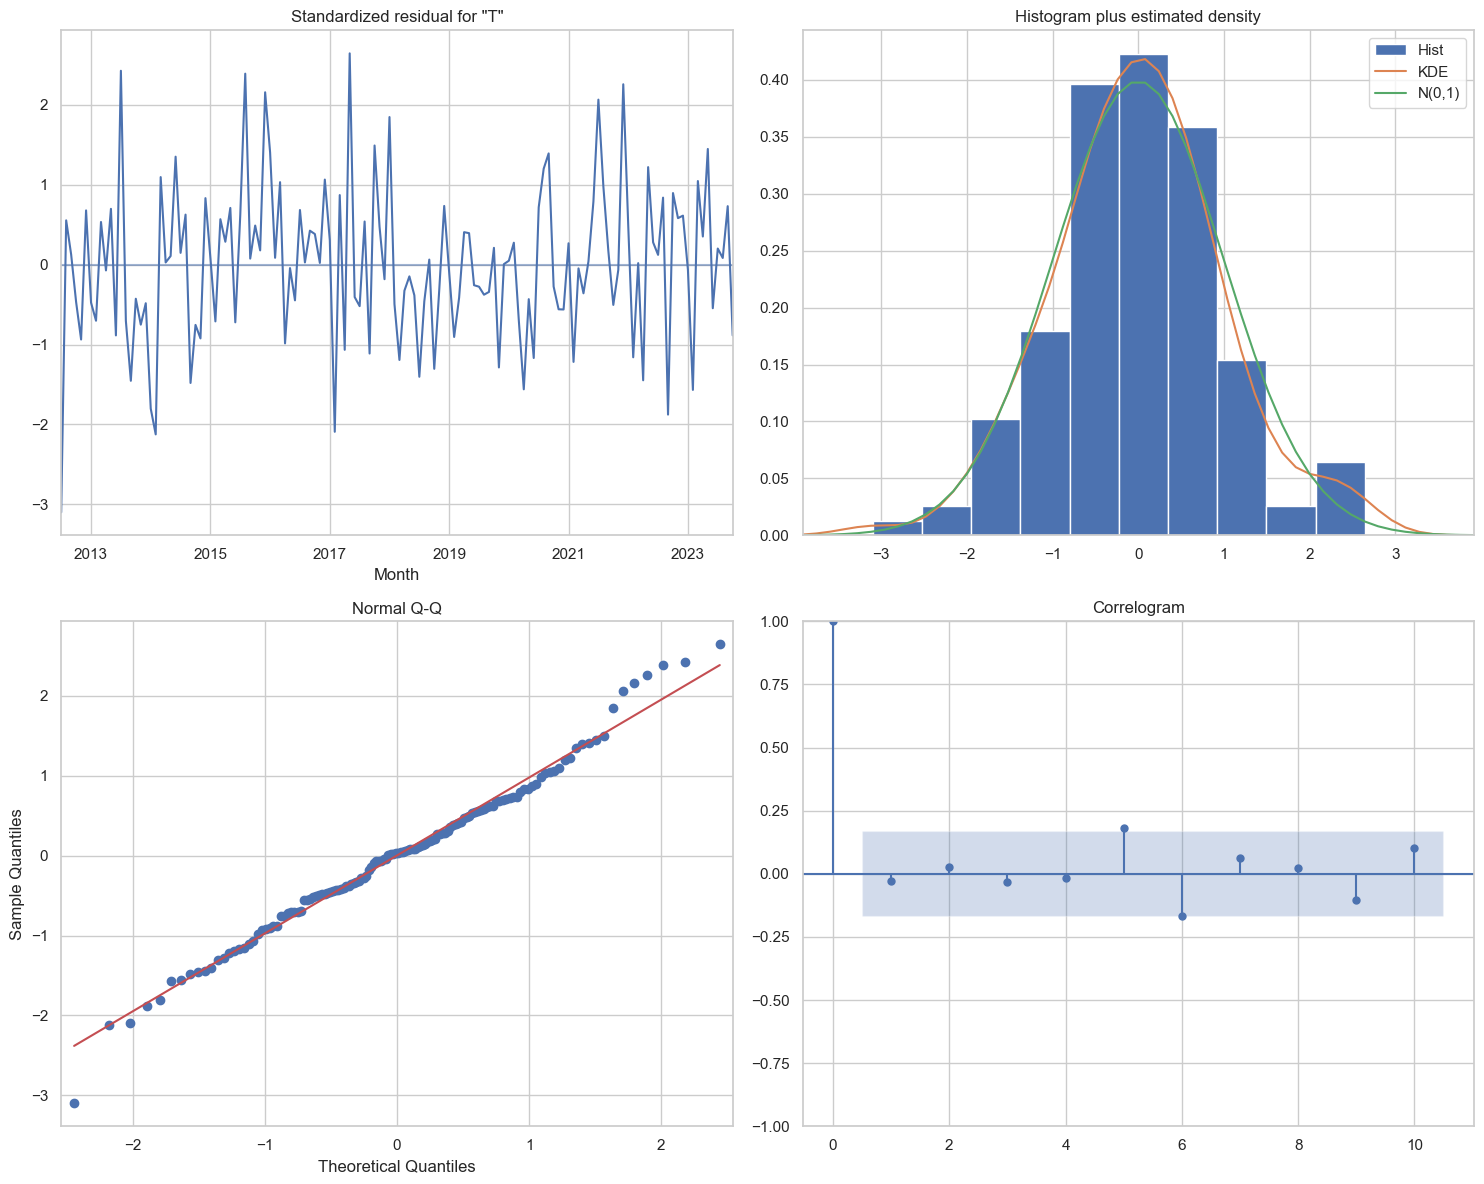

In [184]:
# Build and Evaluate ARIMA Model

# Suppress warnings
warnings.filterwarnings("ignore")

# Ensure monthly_sales is a pandas Series with a DatetimeIndex
if isinstance(timeseriesData, pd.DataFrame):
    timeseriesData = timeseriesData['TotalSales']
timeseriesData = timeseriesData.asfreq('M')

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Grid search to find the best ARIMA model
best_aic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(timeseriesData, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        continue

if best_model is None:
    print("No valid ARIMA model found. Please check your data.")
else:
    print(f'Best ARIMA model: ARIMA{best_pdq} - AIC:{best_aic:.2f}')
    
    # Fit the best model
    model = ARIMA(timeseriesData, order=best_pdq)
    results = model.fit()
    print(results.summary())

    # Optional: Plot diagnostics
    results.plot_diagnostics(figsize=(15, 12))
    plt.tight_layout()
    plt.show();

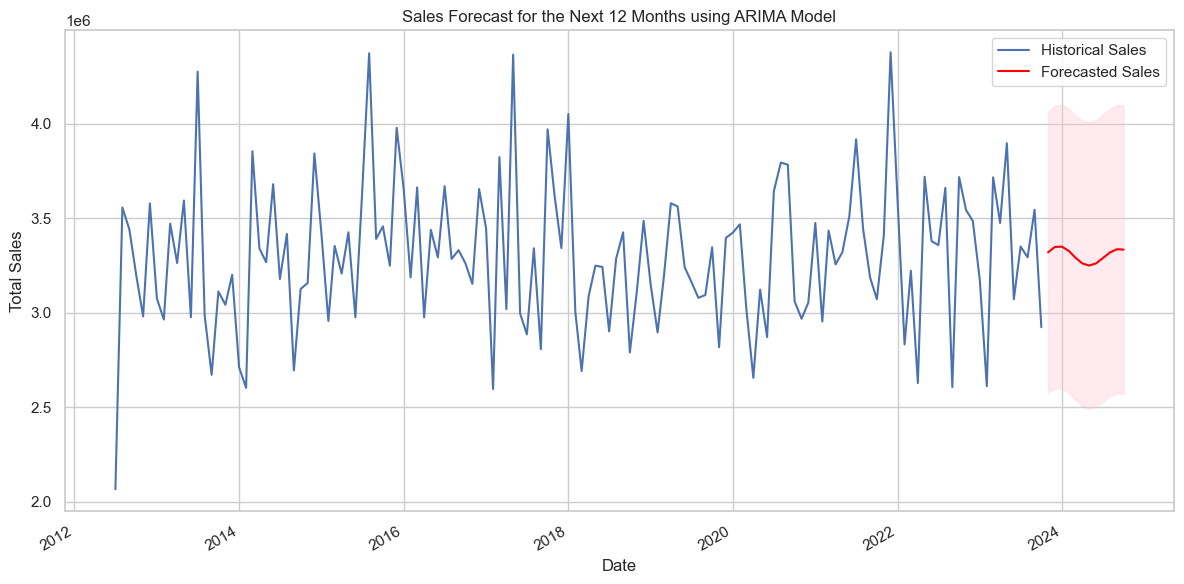

In [186]:
# Forecast Future Sales
# Forecast future sales for a specified period (e.g., 12 months).
# Plot the forecasted sales alongside the historical data

# USING ARIMA MODEL

# Ensure results is defined (output from ARIMA model fitting)
if 'results' not in locals():
    raise ValueError("ARIMA model results not found. Please run the ARIMA model first.")

# Convert PeriodIndex to DatetimeIndex
timeseriesData.index = timeseriesData.index.to_timestamp()

# Forecast for the next 12 months
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start=timeseriesData.index[-1] + pd.Timedelta(days=1), periods=12, freq='M')

# Convert forecast to a DataFrame
forecast_df = forecast.conf_int()
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df.index = forecast_index

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(timeseriesData.index, timeseriesData, label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], color='red', label='Forecasted Sales')
plt.fill_between(forecast_df.index, 
                 forecast_df.iloc[:, 0],  # lower bound
                 forecast_df.iloc[:, 1],  # upper bound
                 color='pink', alpha=0.3)

plt.title('Sales Forecast for the Next 12 Months using ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show();

In [187]:
# Evaluate the Model
# Assess the accuracy of the model using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE).
# Use cross-validation techniques if possible.

# Ensure monthly_sales and forecast_df are aligned
actual_values = timeseriesData[-12:].values
forecasted_values = forecast_df['Forecast'].values

# Calculate performance metrics
mse = mean_squared_error(actual_values, forecasted_values)
mae = mean_absolute_error(actual_values, forecasted_values)
rmse = np.sqrt(mse)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MSE: 125782746555.53
MAE: 286280.75
RMSE: 354658.63


14:26:05 - cmdstanpy - INFO - Chain [1] start processing
14:26:08 - cmdstanpy - INFO - Chain [1] done processing


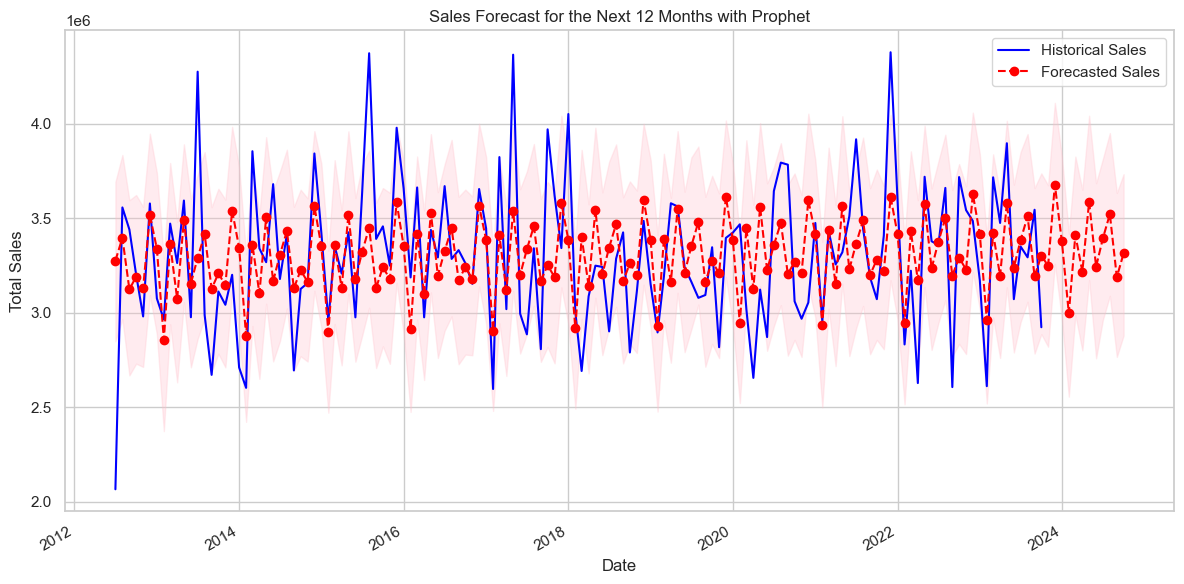

Mean Absolute Error (MAE): 262326.82569466333
Mean Squared Error (MSE): 115447620915.35777
Root Mean Squared Error (RMSE): 339775.8392166191


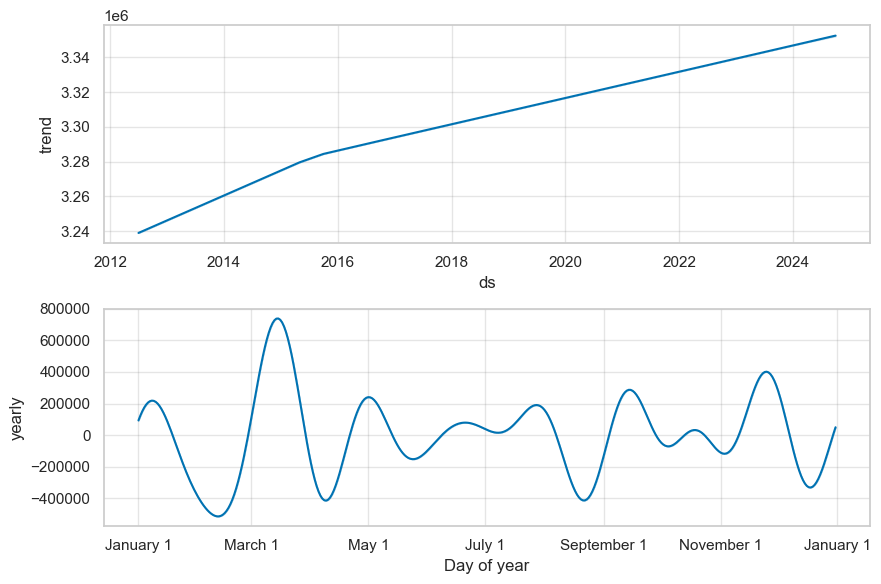

In [188]:
# USING PROPHET MODEL

# Prepare the data for Prophet
prophet_data = timeseriesData.reset_index()
prophet_data.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for the value

# Initialize the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Fit the model
model.fit(prophet_data)

# Forecast for the next 12 months
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Extract forecast values
forecast_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot the historical data
plt.figure(figsize=(12, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical Sales', color='blue')

# Plot the forecast
plt.plot(forecast_values['ds'], forecast_values['yhat'], label='Forecasted Sales', color='red', linestyle='--', marker='o')

# Fill the area between the upper and lower bounds of the forecast
plt.fill_between(forecast_values['ds'], 
                 forecast_values['yhat_lower'], 
                 forecast_values['yhat_upper'], 
                 color='pink', alpha=0.3)

# Add labels, title, and legend
plt.title('Sales Forecast for the Next 12 Months with Prophet')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Evaluate the model
actual = prophet_data['y'].values
predicted = forecast.loc[:len(actual)-1, 'yhat'].values

mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Optional: Plot the forecast components (trend, yearly seasonality)
model.plot_components(forecast)
plt.show();

# QUESTION 6
## Profitability Analysis: Analyze the profitability of different product lines and customer segments, and provide recommendations for improving margins

In [189]:
# Product Line Profitability Analysis
# Merge the datasets
mergedData = pd.merge(orderDetails, products, on='ProductID')
mergedData = pd.merge(mergedData, orders, on='OrderID')

# Calculate profit
mergedData['Profit'] = (mergedData['UnitPrice_x'] * (1 - mergedData['Discount']) - mergedData['UnitPrice_y']) * mergedData['Quantity']
mergedData['ProfitMargin'] = mergedData['Profit'] / (mergedData['UnitPrice_x'] * mergedData['Quantity'])

product_line_analysis = mergedData.groupby('CategoryID').agg({
    'ProductID': 'nunique',
    'Quantity': 'sum',
    'UnitPrice_x': lambda x: (x * mergedData.loc[x.index, 'Quantity'] * (1 - mergedData.loc[x.index, 'Discount'])).sum(),
    'Profit': 'sum',
    'ProfitMargin': 'mean'
}).rename(columns={
    'ProductID': 'ProductCount',
    'Quantity': 'TotalUnitsSold',
    'UnitPrice_x': 'Revenue',
    'ProfitMargin': 'AvgProfitMargin'
}).sort_values('Profit', ascending=False)

product_line_analysis

ProductCount  TotalUnitsSold       Revenue      Profit  \
CategoryID                                                           
5                      7         1412853  2.856853e+07 -11103.4125   
7                      5         1010224  3.270112e+07 -11410.4200   
2                     12         2420864  5.579513e+07 -16295.9150   
8                     12         2410782  4.992160e+07 -17797.7925   
3                     13         2628466  6.633780e+07 -22971.3150   
6                      6         1207892  6.488115e+07 -27660.3305   
4                     10         2020160  5.801812e+07 -34621.0150   
1                     12         2427361  9.216318e+07 -41714.0700   

            AvgProfitMargin  
CategoryID                   
5                 -0.000421  
7                 -0.000429  
2                 -0.000292  
8                 -0.000437  
3                 -0.000453  
6                 -0.000562  
4                 -0.000632  
1                 -0.000568

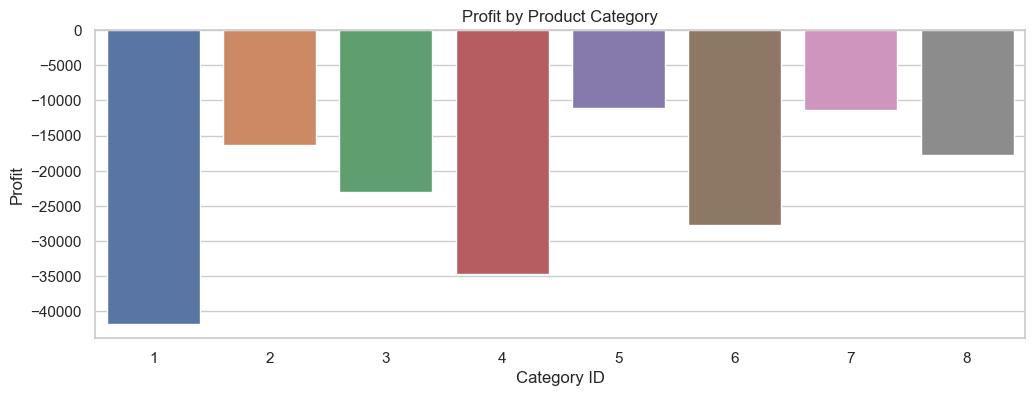

In [190]:
# Visualize product line profitability
plt.figure(figsize=(12, 4))
sns.barplot(x=product_line_analysis.index, y='Profit', data=product_line_analysis)
plt.title('Profit by Product Category')
plt.xlabel('Category ID')
plt.ylabel('Profit')
plt.show();

In [191]:
# Customer Segment Profitability Analysis
customer_segment_analysis = mergedData.groupby('ShipCountry').agg({
    'CustomerID': 'nunique',
    'OrderID': 'nunique',
    'UnitPrice_x': lambda x: (x * mergedData.loc[x.index, 'Quantity'] * (1 - mergedData.loc[x.index, 'Discount'])).sum(),
    'Profit': 'sum',
    'ProfitMargin': 'mean'
}).rename(columns={
    'CustomerID': 'CustomerCount',
    'OrderID': 'OrderCount',
    'UnitPrice_x': 'Revenue',
    'ProfitMargin': 'AvgProfitMargin'
}).sort_values('Profit', ascending=False)

customer_segment_analysis.head(10)

CustomerCount  OrderCount       Revenue     Profit  \
ShipCountry                                                       
Poland                  82         213  5.956183e+06  -114.7500   
Argentina               93         535  1.554224e+07  -191.7800   
Norway                  76         164  4.599280e+06  -265.2000   
Italy                   93         538  1.444303e+07 -1863.7550   
Mexico                  93         899  2.543811e+07 -1979.6325   
Spain                   93         691  1.913468e+07 -2312.2800   
Portugal                89         357  1.012155e+07 -2540.5375   
Finland                 92         369  9.817004e+06 -2818.5975   
Switzerland             92         367  1.027456e+07 -2853.8910   
Belgium                 92         338  9.181163e+06 -4524.1250   

             AvgProfitMargin  
ShipCountry                   
Poland             -0.000062  
Argentina          -0.000048  
Norway             -0.000161  
Italy              -0.000334  
Mexico             -0.000204  
Spain              -0.000241  
Portugal           -0.000534  
Finland            -0.000446  
Switzerland        -0.000402  
Belgium            -0.000492

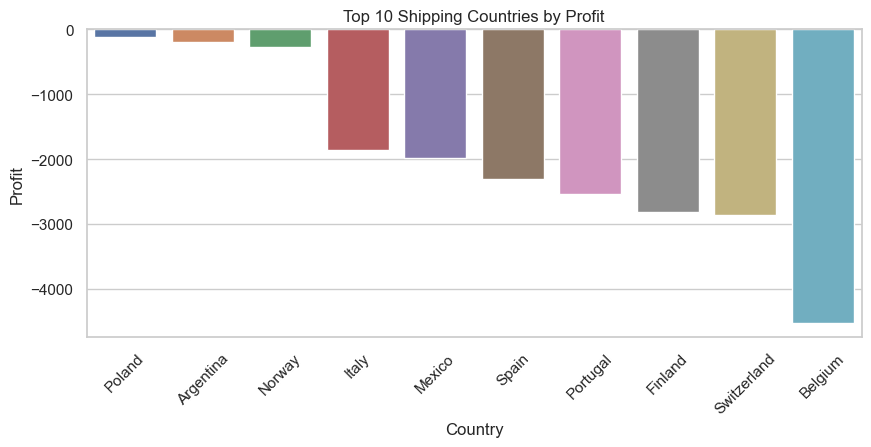

In [192]:
# Visualize top 10 countries by profit
plt.figure(figsize=(10, 4))
sns.barplot(x=customer_segment_analysis.head(10).index, y='Profit', data=customer_segment_analysis.head(10))
plt.title('Top 10 Shipping Countries by Profit')
plt.xlabel('Country')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.show();

In [193]:
# Margin Analysis
margin_analysis = mergedData.groupby(['ProductID', 'ProductName', 'CategoryID']).agg({
    'ProfitMargin': 'mean',
    'Quantity': 'sum',
    'Profit': 'sum'
}).rename(columns={
    'ProfitMargin': 'AvgProfitMargin',
    'Quantity': 'TotalUnitsSold'
}).sort_values('AvgProfitMargin', ascending=False)

margin_analysis.head(10)

AvgProfitMargin  \
ProductID ProductName                  CategoryID                    
15        Genen Shouyu                 2                 -0.000075   
9         Mishi Kobe Niku              6                 -0.000095   
22        Gustaf's Knäckebröd          5                 -0.000101   
67        Laughing Lumberjack Lager    1                 -0.000108   
6         Grandma's Boysenberry Spread 2                 -0.000110   
3         Aniseed Syrup                2                 -0.000120   
27        Schoggi Schokolade           3                 -0.000127   
37        Gravad lax                   8                 -0.000134   
48        Chocolade                    3                 -0.000146   
66        Louisiana Hot Spiced Okra    2                 -0.000155   

                                                   TotalUnitsSold     Profit  
ProductID ProductName                  CategoryID                             
15        Genen Shouyu                 2                   201697  -106.1750  
9         Mishi Kobe Niku              6                   200258 -1988.5000  
22        Gustaf's Knäckebröd          5                   200234  -185.6400  
67        Laughing Lumberjack Lager    1                   201541  -179.2000  
6         Grandma's Boysenberry Spread 2                   201515  -388.0000  
3         Aniseed Syrup                2                   202186  -236.0000  
27        Schoggi Schokolade           3                   201139  -923.6250  
37        Gravad lax                   8                   201750  -561.6000  
48        Chocolade                    3                   201732  -390.7875  
66        Louisiana Hot Spiced Okra    2                   206213  -680.0000

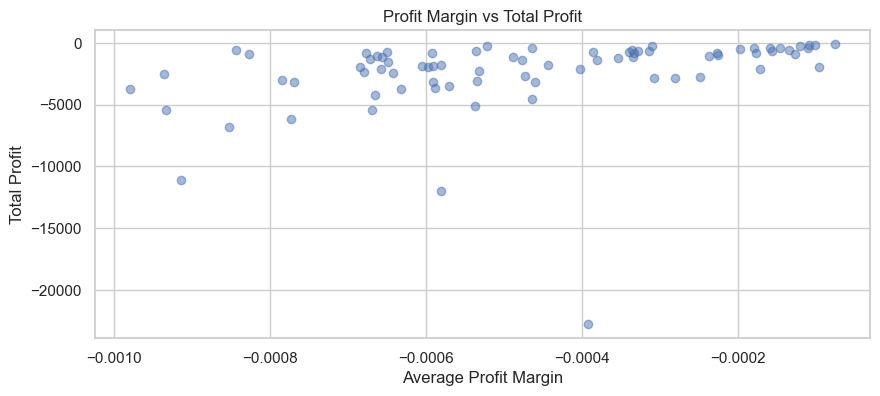

In [194]:
# Visualize relationship between profit margin and total profit
plt.figure(figsize=(10, 4))
plt.scatter(margin_analysis['AvgProfitMargin'], margin_analysis['Profit'], alpha=0.5)
plt.title('Profit Margin vs Total Profit')
plt.xlabel('Average Profit Margin')
plt.ylabel('Total Profit')
plt.show();

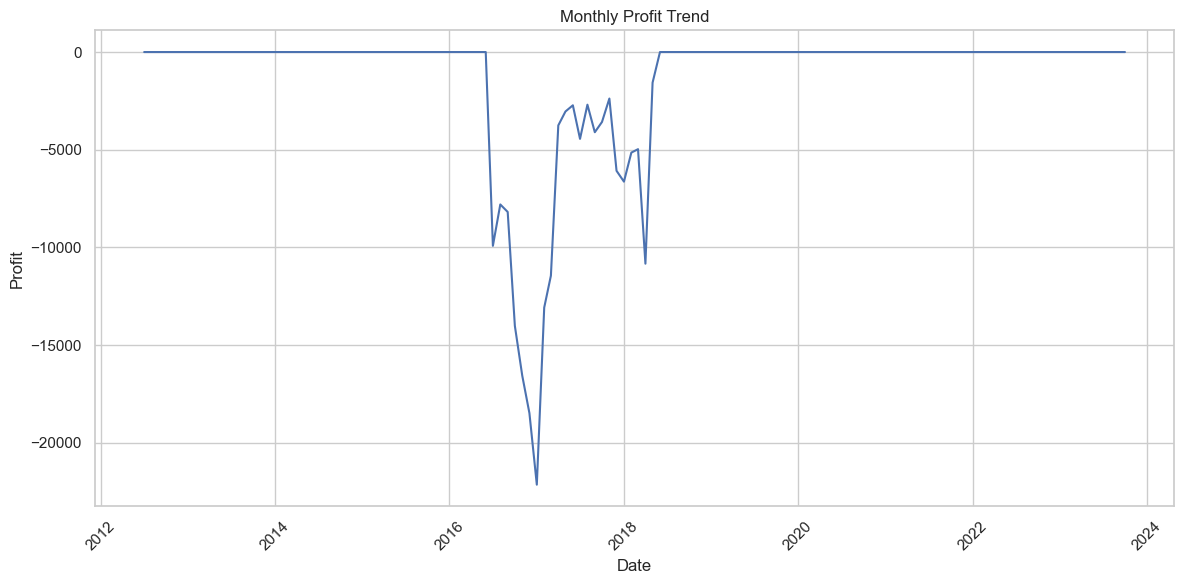

In [195]:
# Time Trend

timeTrendData = merged_data.copy()
timeTrendData['OrderDate'] = pd.to_datetime(timeTrendData['OrderDate'])

# Group by month and calculate total profit
monthly_profit = timeTrendData.groupby(timeTrendData['OrderDate'].dt.to_period('M')).agg({
    'Profit': 'sum'
}).reset_index()

monthly_profit['OrderDate'] = monthly_profit['OrderDate'].dt.to_timestamp()

# Plot time trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_profit['OrderDate'], monthly_profit['Profit'])
plt.title('Monthly Profit Trend')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

## Thank you for Reading...